In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
from os.path import exists

global count
global count2
count = 0
count2 =0

In [18]:
class Metropolis:
    def __init__(self,L,J=1,B=0,isTinf=False):
        self.L = L
        self.N = L*L
        self.J = J
        self.B = B
        count1 = 0
        count2 = 0
        
        self.sc = np.ones(self.N,dtype=np.int0)
        if(isTinf):
            self.sc = np.array([1-(int)(np.random.rand()*2)*2 for i in range(self.N)],dtype=np.int0)
        self.prob = np.zeros(2,dtype=np.double)

    def prob_calc(self,beta):
        for i in range(2):
            # 4 8
            self.prob[i] = np.exp(-beta*4*(i+1))

    def measure(self,func):
        res = 0
        # print(self.sc)
        for i in range(self.N):
            sum = func(i)
            res += self.J*sum*self.sc[i]

        sigma = np.sum(self.sc)
        HH = -res -self.B*sigma

        return sigma, HH

    def helical(self,i):
        sum = 0

        nn = i + 1
        if(nn == self.N): nn = 0
        sum += self.sc[nn]

        nn = i + self.L
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]
        return sum

    
    def sweep_pbc(self,i):
        sum = 0

        nn = i -1
        if((nn+1 % self.L) == 0) : nn += self.L
        sum += self.sc[nn]

        nn = i + 1
        if(nn % self.L == 0): nn -= self.L
        sum += self.sc[nn]

        nn = i - self.L
        if(nn < 0): nn += self.N
        sum += self.sc[nn]

        nn = i + self.L
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]
        return sum
    
    def sweep_helical(self,i):
        sum = 0

        nn = i -1
        if(nn < 0) : nn += self.N
        sum += self.sc[nn]

        nn = i + 1
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]

        nn = i - self.L
        if(nn < 0): nn += self.N
        sum += self.sc[nn]

        nn = i + self.L
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]
        return sum

    def calculate(self,random=False):
        global count, count2
        for i in range(self.N):
            if(random):
                k = np.random.randint(0,self.N-1)
            elif (self.N%2 ==0):
                k = 2*i
                if(k < self.N): k = k if int(k/self.L)%2 ==0 else k+1
                else:
                    k -= self.N
                    k = k+1 if int(k/self.L)%2 ==0 else k
            else:
                k = 2*i if 2*i < self.N else 2*i-self.N
            # print(k,'')

            # delta = Enew - Eold
            delta = 2*self.sc[k]*self.J*self.sweep_helical(k)
            count2 += 1
            # print(delta)
            if(delta <= 0): # A = 1
                count += 1
                self.sc[k] *= -1
            elif(np.random.rand() < self.prob[int(delta/4)-1]): #flip
                # print(delta, self.prob[int(delta/4)-1])
                count += 1
                self.sc[k] *= -1
        return 2*self.sc[k], delta

    def calculate2(self,random=False):
        global count, count2
        for i in range(self.N):
            k = i ## 순서대로 하고 있었네?
            if(random):
                k = np.random.randint(self.N)
            # delta = Enew - Eold
            delta = 2*self.sc[k]*self.J*self.sweep_pbc(k)
            count2 += 1
            # print(delta)
            if(delta <= 0): # A = 1
                count += 1
                self.sc[k] *= -1
            elif(np.random.rand() < self.prob[int(delta/4)-1]): #flip
                # print(delta, self.prob[int(delta/4)-1])
                count += 1
                self.sc[k] *= -1
        return 2*self.sc[k], delta

In [19]:
# Figure for equilibrium
def Equilibrium_drawer(T,factor = 1, mcs = 1000, N=100):
    T11 = Metropolis(N)
    T11.prob_calc(1/T)
    ls , mcs = np.array([10,20,40,60,100,200,400,1000,10000]), mcs
    ls , mcs = factor*ls, factor*mcs
    # ls = [1,2,4,6,10,20,40,100,1000]
    cnt = 0
    plt.figure(figsize=(8,8))
    # plt.subplots(constrained_layout=True)
    plt.subplot(3,3,1,aspect='equal')
    plt.axis('off')
    a = np.reshape(T11.sc,(T11.L,T11.L))
    plt.title("mcs =" + "0" +", |m| = " + str(np.abs(np.sum(T11.sc)/T11.N)))
    plt.imshow(a,cmap="gray")

    for i in range(mcs+1):
        if(i == ls[cnt]):
            cnt += 1
            plt.subplot(3,3,cnt+1)
            plt.axis('off')
            a = np.reshape(T11.sc,(T11.L,T11.L))
            plt.title("mcs =" + str(ls[cnt-1]) +", |m| = " + str(np.abs(np.sum(T11.sc)/T11.N)))
            plt.imshow(a,cmap="Greys")
            print("cnt =",ls[cnt-1])
        T11.calculate()
    plt.subplots_adjust(right=0.9,top=0.9, wspace=0.2, hspace=0.2)
    # plt.subplot_tool()
    plt.figure(dpi=600)
    plt.show()

In [20]:
# Equilibrium_drawer(2.6)
# Equilibrium_drawer(2.27,factor = 3)
# Equilibrium_drawer(1.9, factor = 2)

In [21]:
#autocorrection time
def __auto__(T_auto,isTinf,random,helical=True):
    epoch = 10000 #mcs

    mlist = np.zeros(epoch)

    M100100 = Metropolis(100,isTinf=isTinf)
    M100100.prob_calc(1/T_auto)
    for i in range(epoch):
        if(helical):
            M100100.calculate(random=random)
        else:
            M100100.calculate2(random=random)
        sigma, HH = M100100.measure(M100100.helical)
        mlist[i] = sigma/10000
    return mlist

def chi1(mlist):
    epoch = len(mlist)
    auto_chi1 = np.zeros(epoch)
    mlist2 = mlist-np.average(mlist)
    for i in range(epoch):
        auto_chi1[i] = np.average(mlist2[0:epoch-i]*mlist2[i:epoch])
    return auto_chi1

def chi2(mlist):
    epoch = len(mlist)
    auto_chi2 = np.zeros(epoch)
    for i in range(epoch):
        auto_chi2[i] = np.sum(mlist[0:epoch-i]*mlist[i:epoch])/(epoch-i) -np.sum(mlist[0:epoch-i])*np.sum(mlist[i:epoch])/(epoch-1)**2
    return auto_chi2

def tau_drawer(mlist, auto_chi1, auto_chi2, _bin2 = 150, slice = [250,500,1000,5000,10000], draw_fitting = [1,2,3]):
    ## Drawing time vs. magnetizaiton
    mag_fig_drawer(mlist)
    # slice = [250,500,1000,5000,10000]
    # draw_fitting = [1,2,3]
    cnt = 1
    size = len(slice)

    ## Fitting calculation
    # _bin2 = 150
    x = np.arange(0,_bin2)
    y = auto_chi1[0:_bin2]
    if(draw_fitting[0] != None):
        tt = np.polyfit(x,np.log(y),1,w=np.sqrt(y))

    ## Drawing subplots of time vs autocorrelation of m
    plt.figure(dpi=600)
    plt.figure(figsize=(16,8))
    plt.style.use('seaborn-whitegrid')

    for _bin in slice:
        xx = np.arange(0,_bin)

        plt.subplot(2,size,cnt)
        plt.plot(xx,auto_chi1[0:_bin]/auto_chi1[0],label="$\chi_1$")
        plt.plot(xx,auto_chi2[0:_bin]/auto_chi2[0],label="$\chi_2$")
        plt.axhline(1/np.e,linestyle='--',lw=1)
        plt.axhline(1/np.e**2,linestyle='--',lw=1)
        plt.xlim(0,_bin)
        plt.ylim(None,1.0)
        if cnt in draw_fitting:
            aa = np.arange(0,_bin)
            bb = np.exp(tt[1]) *np.exp(tt[0]*aa)
            plt.plot(aa,bb/max(bb),linestyle='--',lw=1,color='black',label="$\exp(-t/\\tau)$")
        if cnt == 1:
            plt.ylabel('Magnetization autocorrelation $\chi(t)/\chi(0)$')
            plt.legend()
        plt.xlabel('Time (or mcs) $t$')



        plt.subplot(2,size,cnt+size)
        plt.semilogy(xx,auto_chi1[0:_bin]/auto_chi1[0],label="$\chi_1$")
        plt.semilogy(xx,auto_chi2[0:_bin]/auto_chi2[0],label="$\chi_2$")
        plt.axhline(1/np.e,linestyle='--',lw=1)
        plt.axhline(1/np.e**2,linestyle='--',lw=1)
        plt.xlim(0,_bin)
        plt.ylim(None,1.0)
        if cnt in draw_fitting:
            aa = np.arange(0,_bin)
            bb = np.exp(tt[1]) *np.exp(tt[0]*aa)
            plt.plot(aa,bb/max(bb),linestyle='--',lw=1,color='black',label="$\exp(-t/\\tau)$")
        if cnt == 1:
            plt.ylabel('Magnetization autocorrelation $\chi(t)/\chi(0)$')
            plt.legend()
        plt.xlabel('Time (or mcs) $t$')
        cnt = cnt + 1

    plt.show()
    if(draw_fitting[0] != None):
        print("tau is", -1/tt[0])

def mag_fig_drawer(mlist):
    plt.figure(dpi=600)
    plt.style.use('seaborn-whitegrid')
    plt.axhline(np.average(mlist),c='red',lw=1)
    plt.plot(np.arange(0,len(mlist)),mlist)
    plt.ylim(None,1)
    plt.xlim(0,len(mlist))
    plt.ylabel('Magnetization $m$')
    plt.xlabel('Time (or mcs) $t$')
    plt.show()
    print("<m> is ",np.average(mlist))

def save_auto_data(data,path):
    f = open(path,'w')
    # f.write(np.array2string(data, precision=6, separator=',')[1:-1])
    data.flatten().tofile(f)
    f.close()

def load_auto_data(path):
    if(not exists(path)): return False, None
    f = open(path,'r')
    # line = f.readline()
    # # res = np.array([np.array(line.strip().split(','),dtype=np.double)],dtype=object)
    # res =np.fromstring(line,dtype=np.double,sep=',')
    res = np.fromfile(f)
    return True, res

def tau_drawer_2(mag_fig):
    fig_args = [mag_fig,chi1(mag_fig),chi2(mag_fig)]
    tau_drawer(fig_args[0],fig_args[1],fig_args[2])

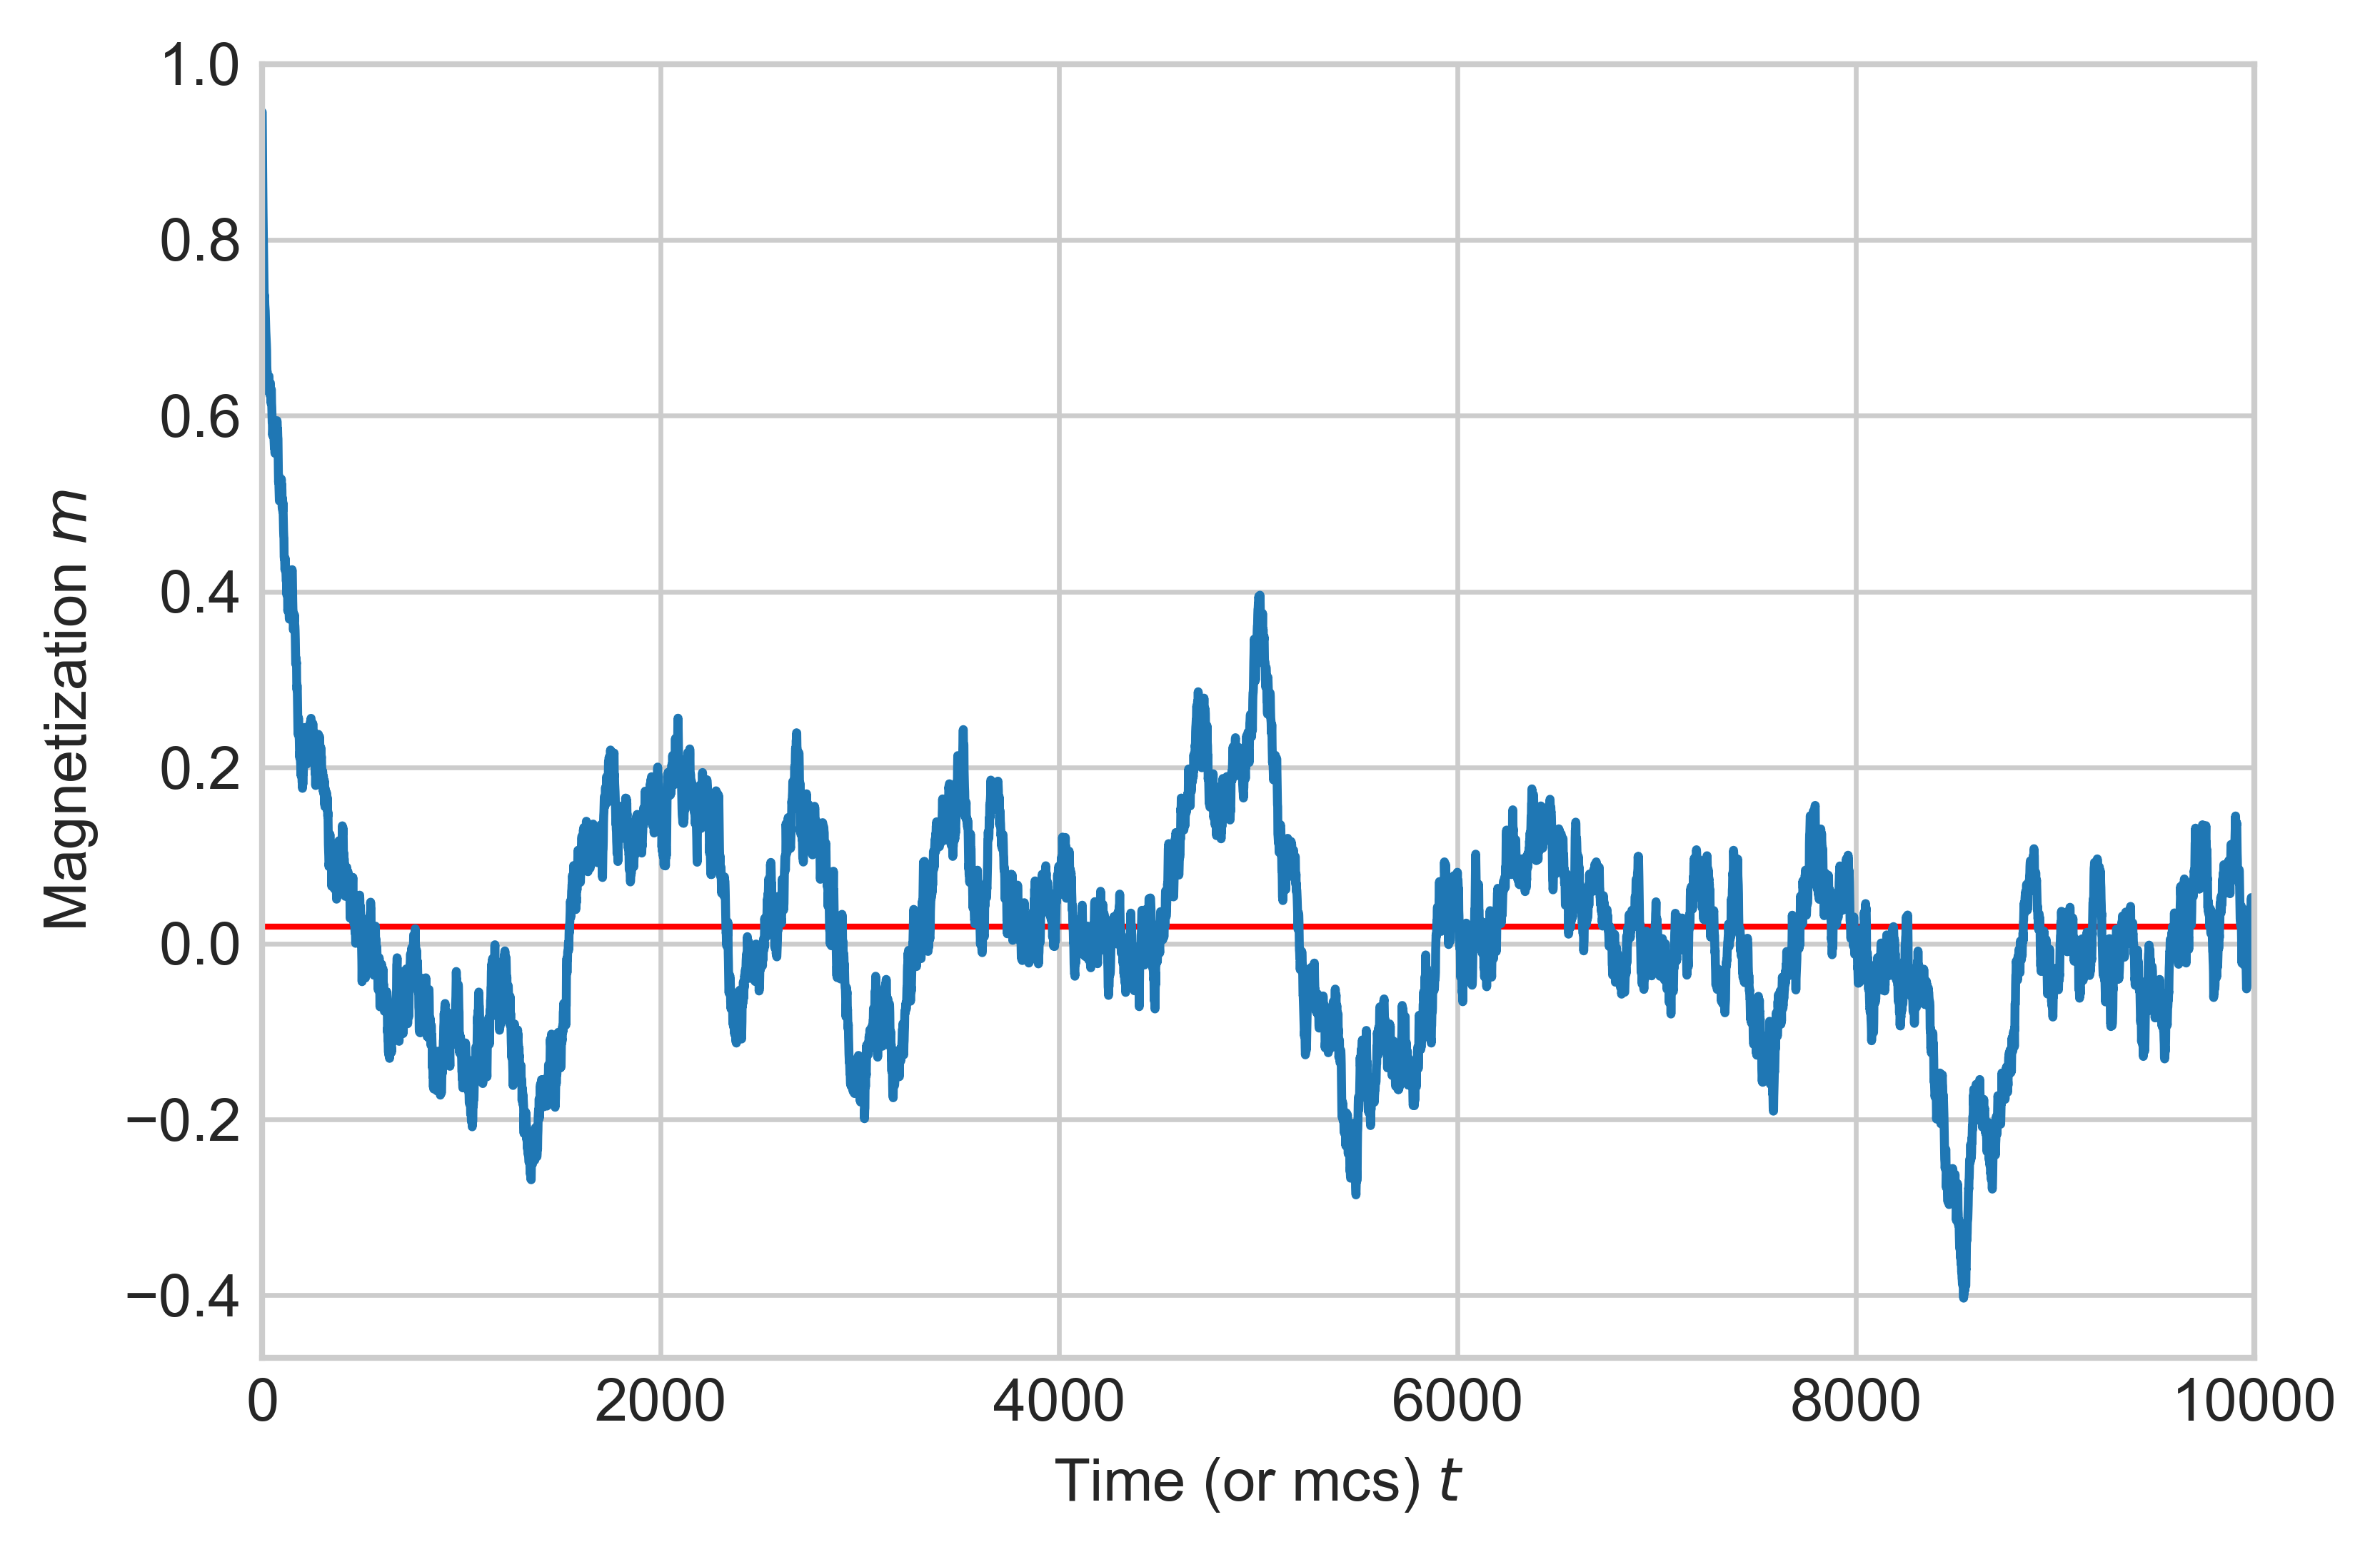

<m> is  0.01896904


<Figure size 3600x2400 with 0 Axes>

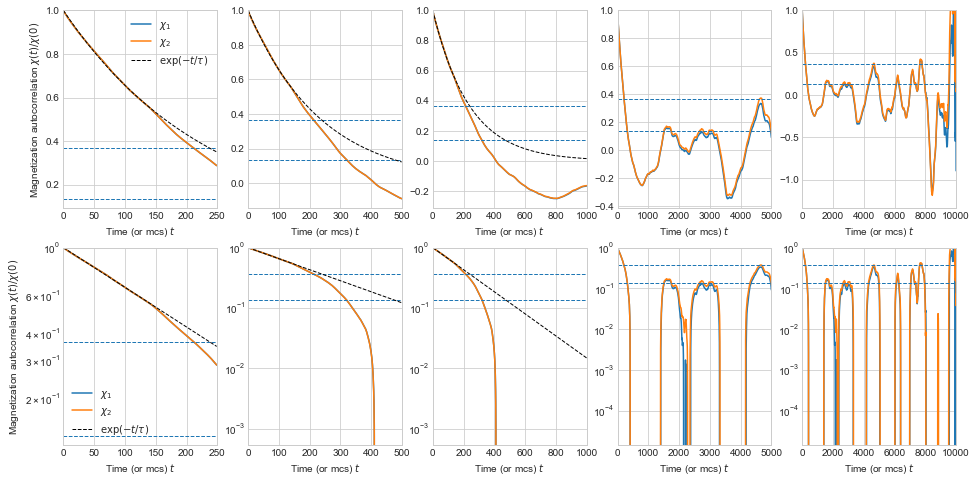

tau is 237.2842014957483


In [22]:
# isTinf = False, Pick Random site = True
exist, mag_fig1 = load_auto_data("Result/mag_fig/np_mag_fig1.txt")
if(not exist):
    mag_fig1 = __auto__(2.4,False,True)
    save_auto_data(mag_fig1,"Result/mag_fig/np_mag_fig1.txt")
tau_drawer_2(mag_fig1)

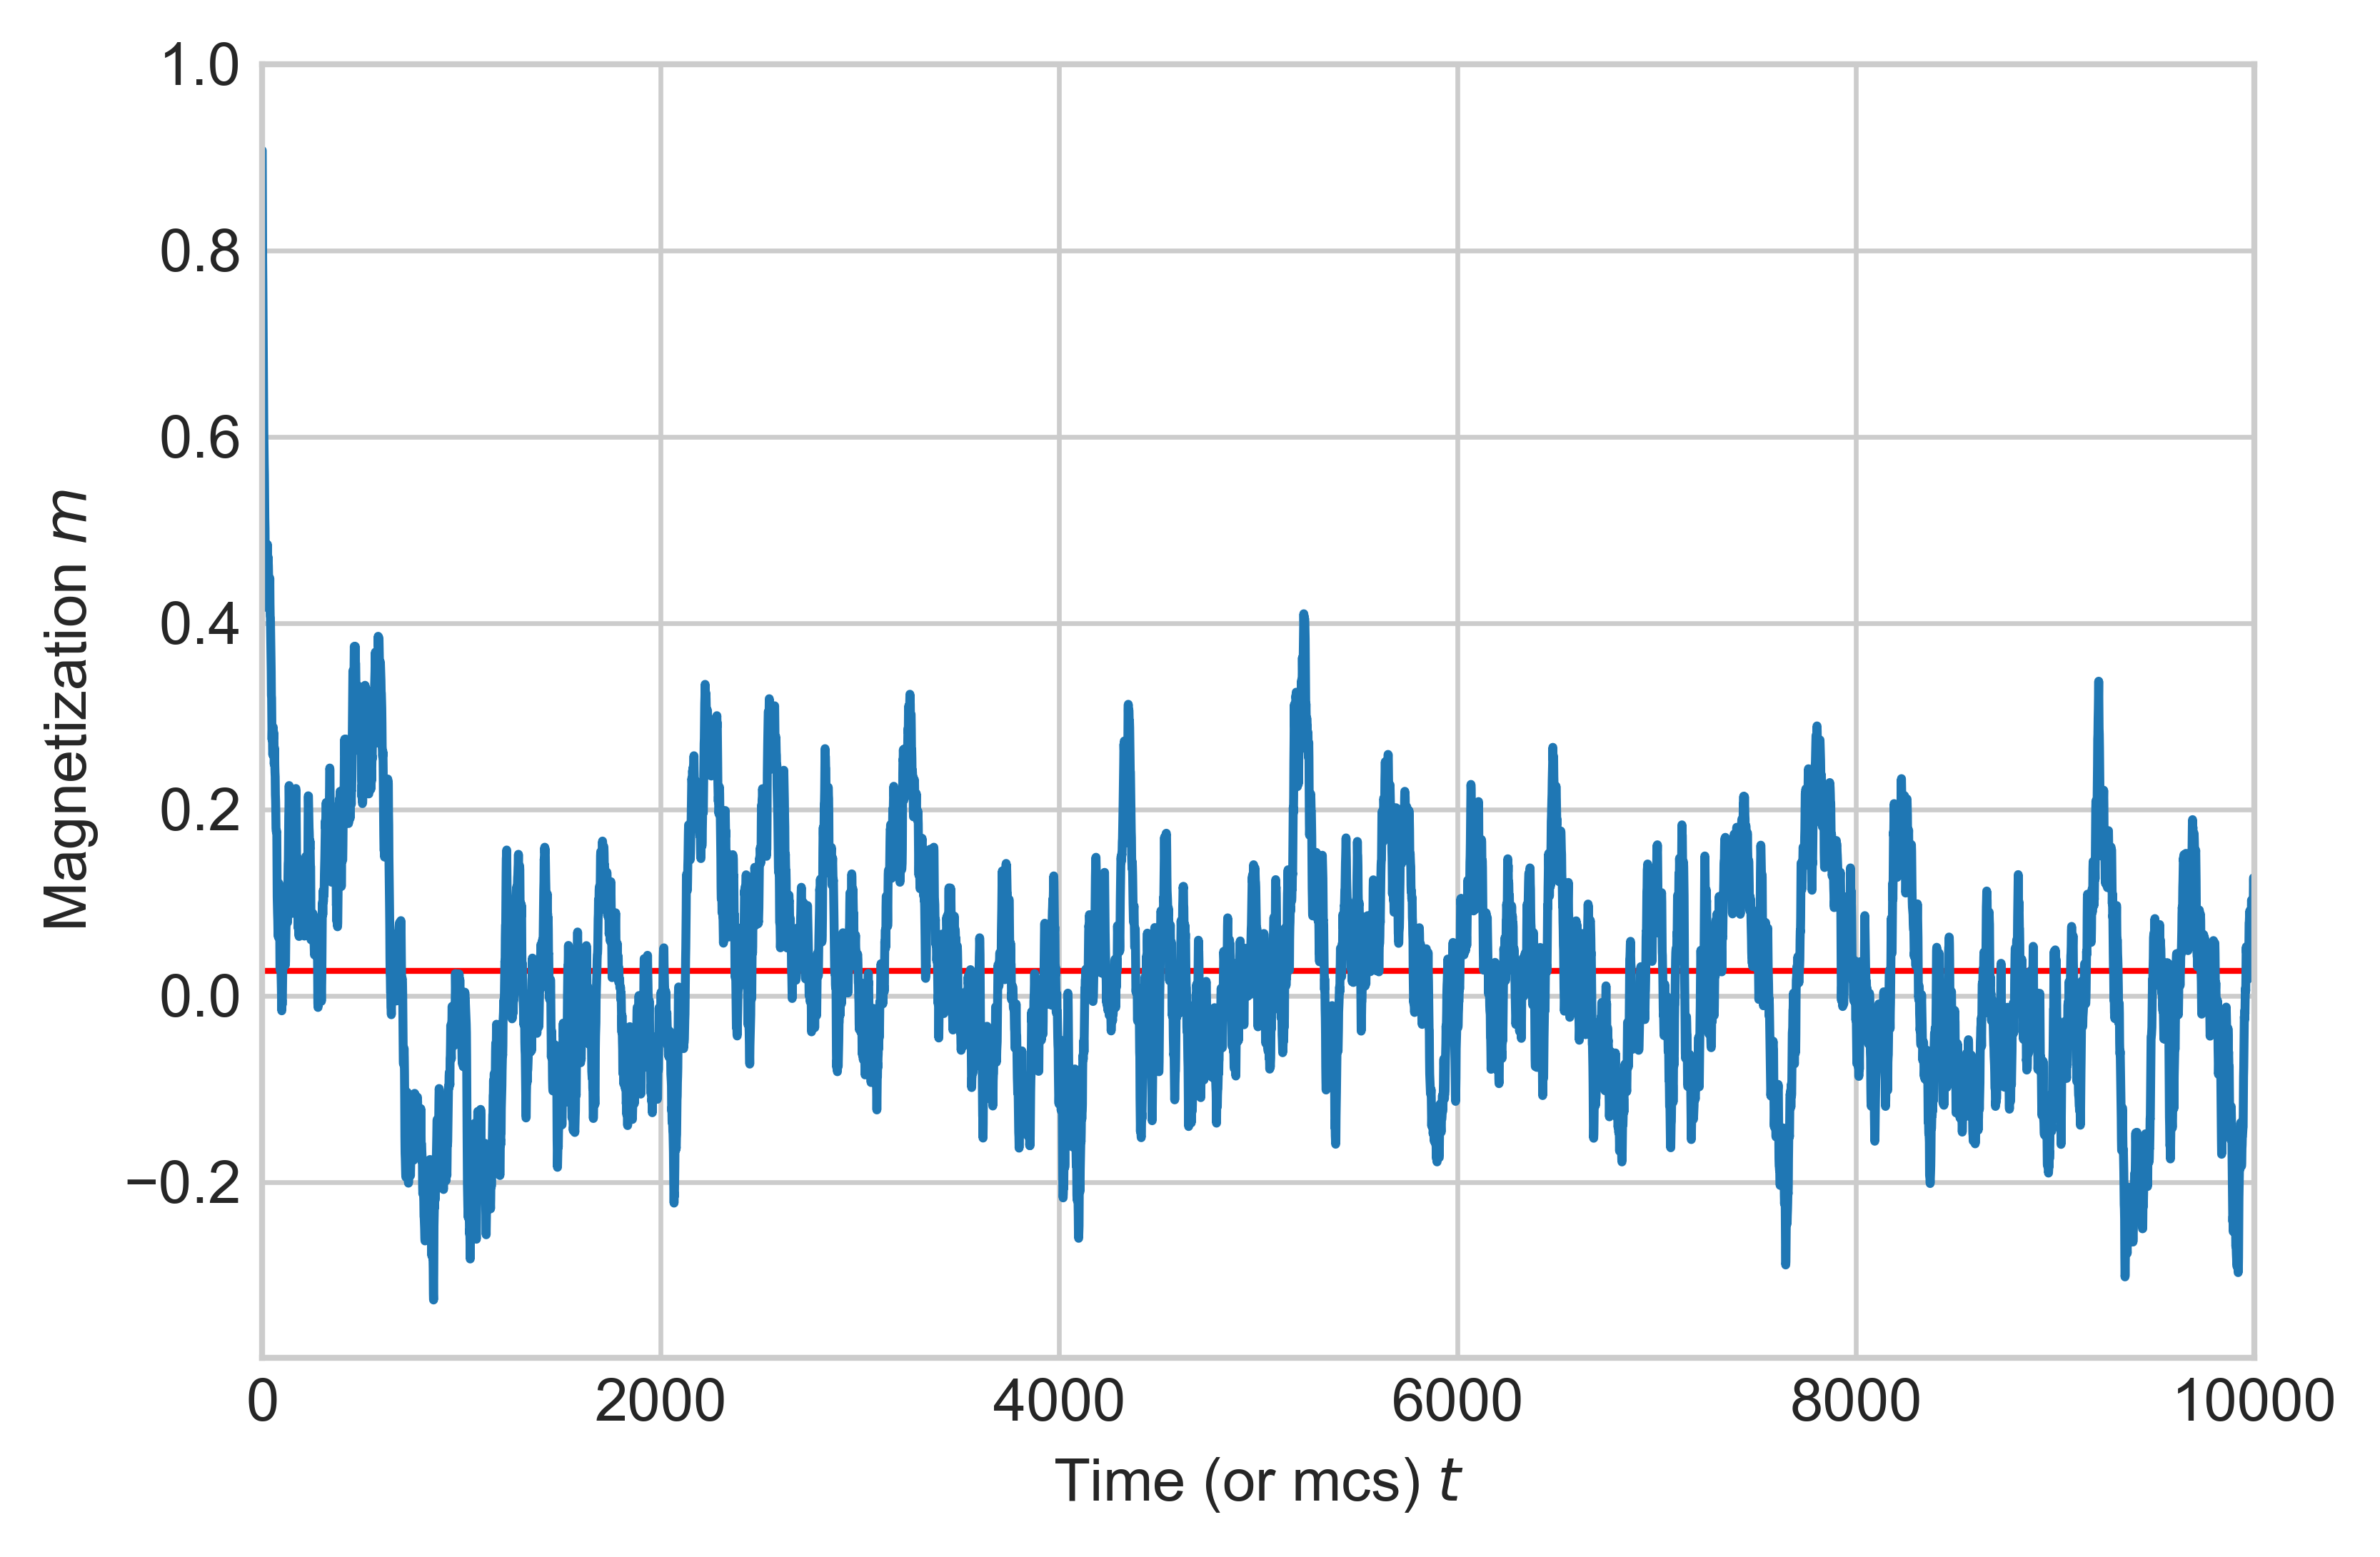

<m> is  0.026780400000000003


<Figure size 3600x2400 with 0 Axes>

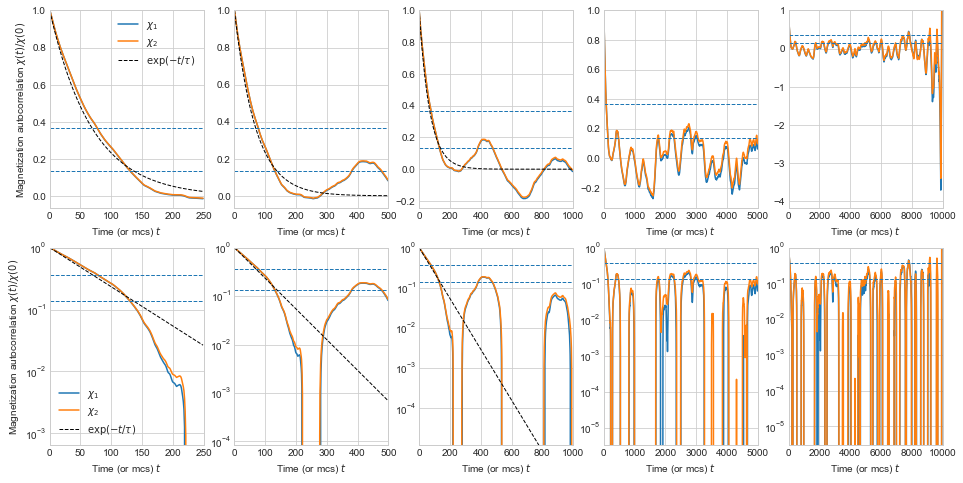

tau is 68.61009808206344


In [23]:
## Drawing time vs. magnetizaiton
# isTinf = False, Pick Random site = False
exist, mag_fig2 = load_auto_data("Result/mag_fig/np_mag_fig2.txt")
if(not exist):
    mag_fig2 = __auto__(2.4,False,False)
    save_auto_data(mag_fig2,"Result/mag_fig/np_mag_fig2.txt")
tau_drawer_2(mag_fig2)

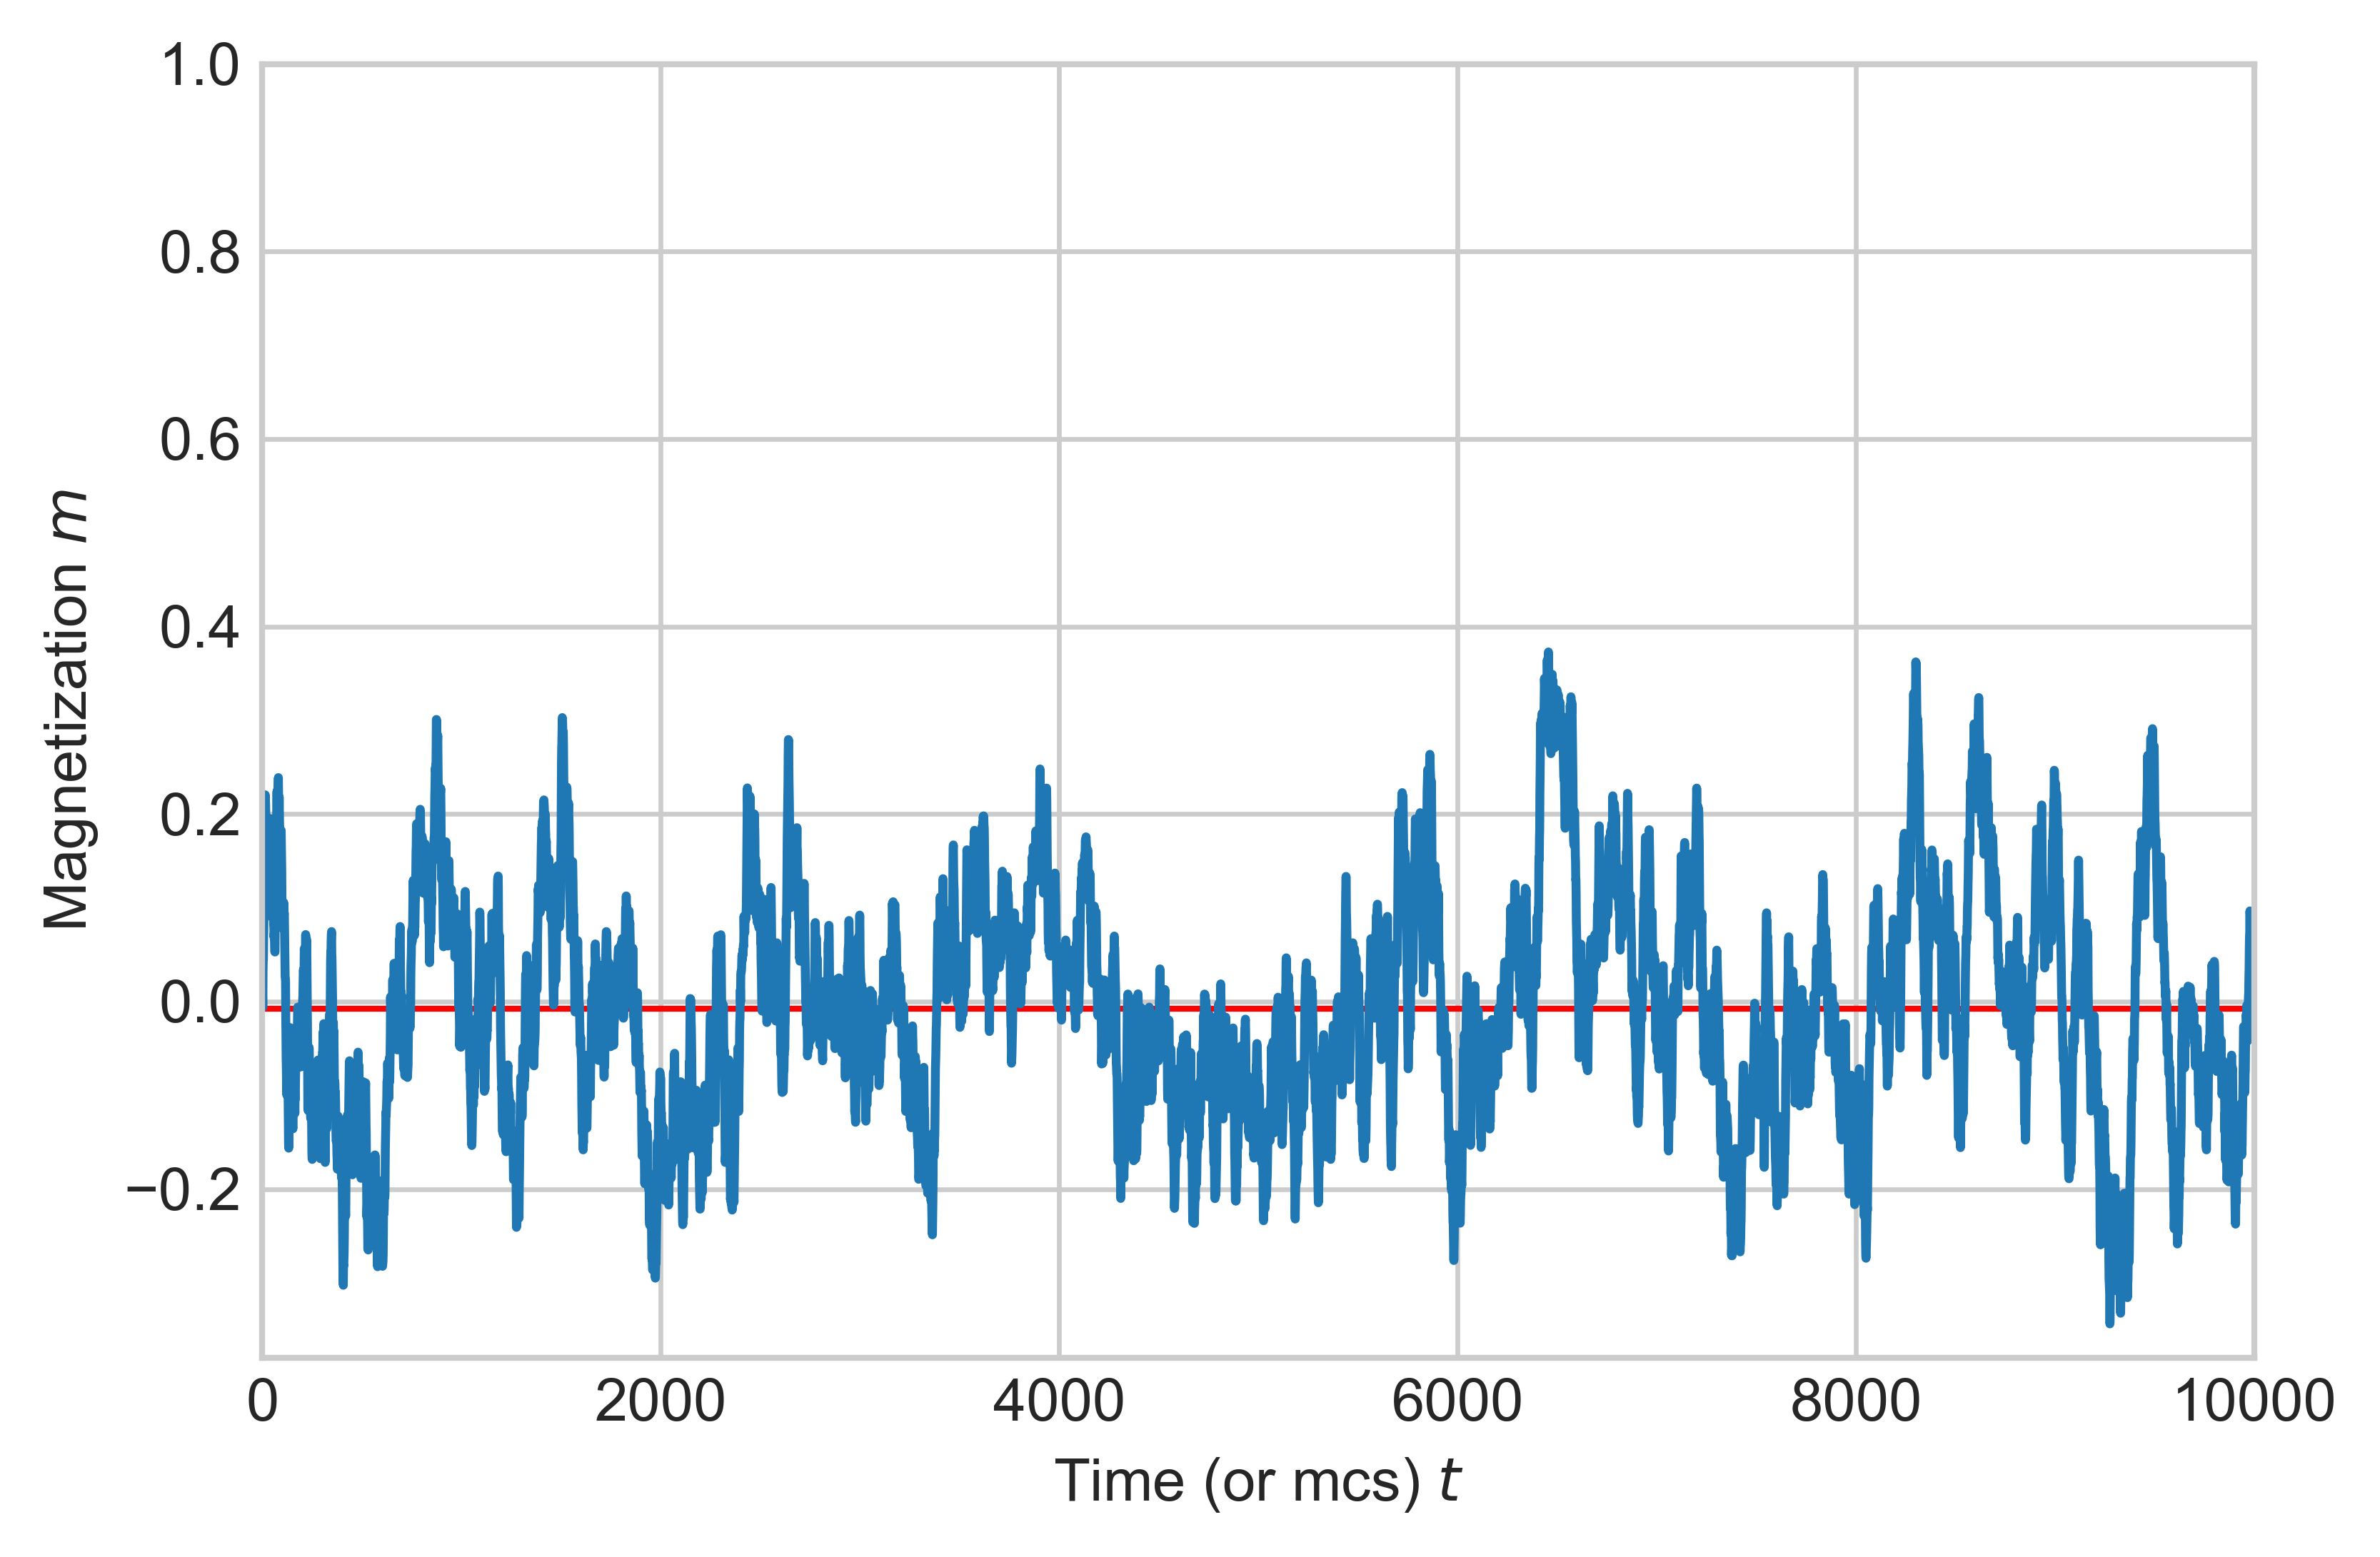

<m> is  -0.007907139999999997


<Figure size 3600x2400 with 0 Axes>

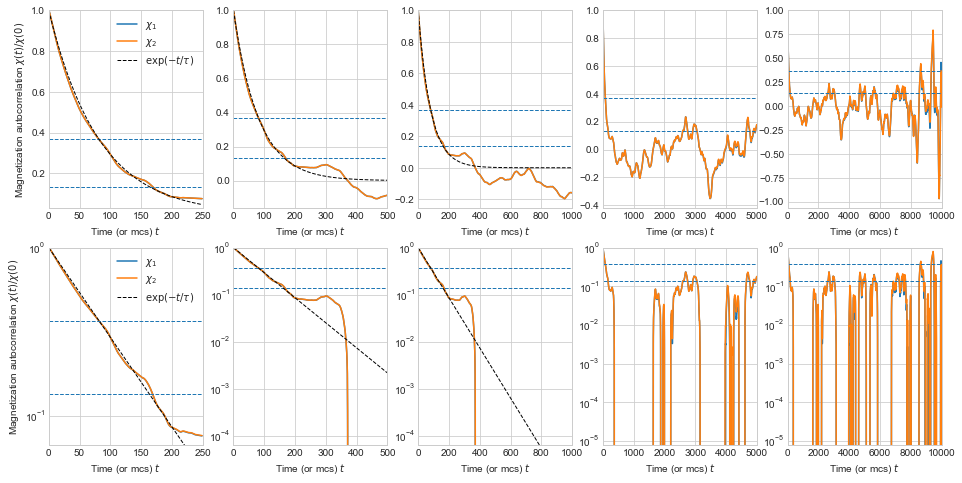

tau is 81.53515748736523


In [24]:
## Drawing time vs. magnetizaiton
# isTinf = True, Pick Random site = False
exist, mag_fig3 = load_auto_data("Result/mag_fig/np_mag_fig3.txt")
if(not exist):
    mag_fig3 = __auto__(2.4,True,False)
    save_auto_data(mag_fig3,"Result/mag_fig/np_mag_fig3.txt")
tau_drawer_2(mag_fig3)

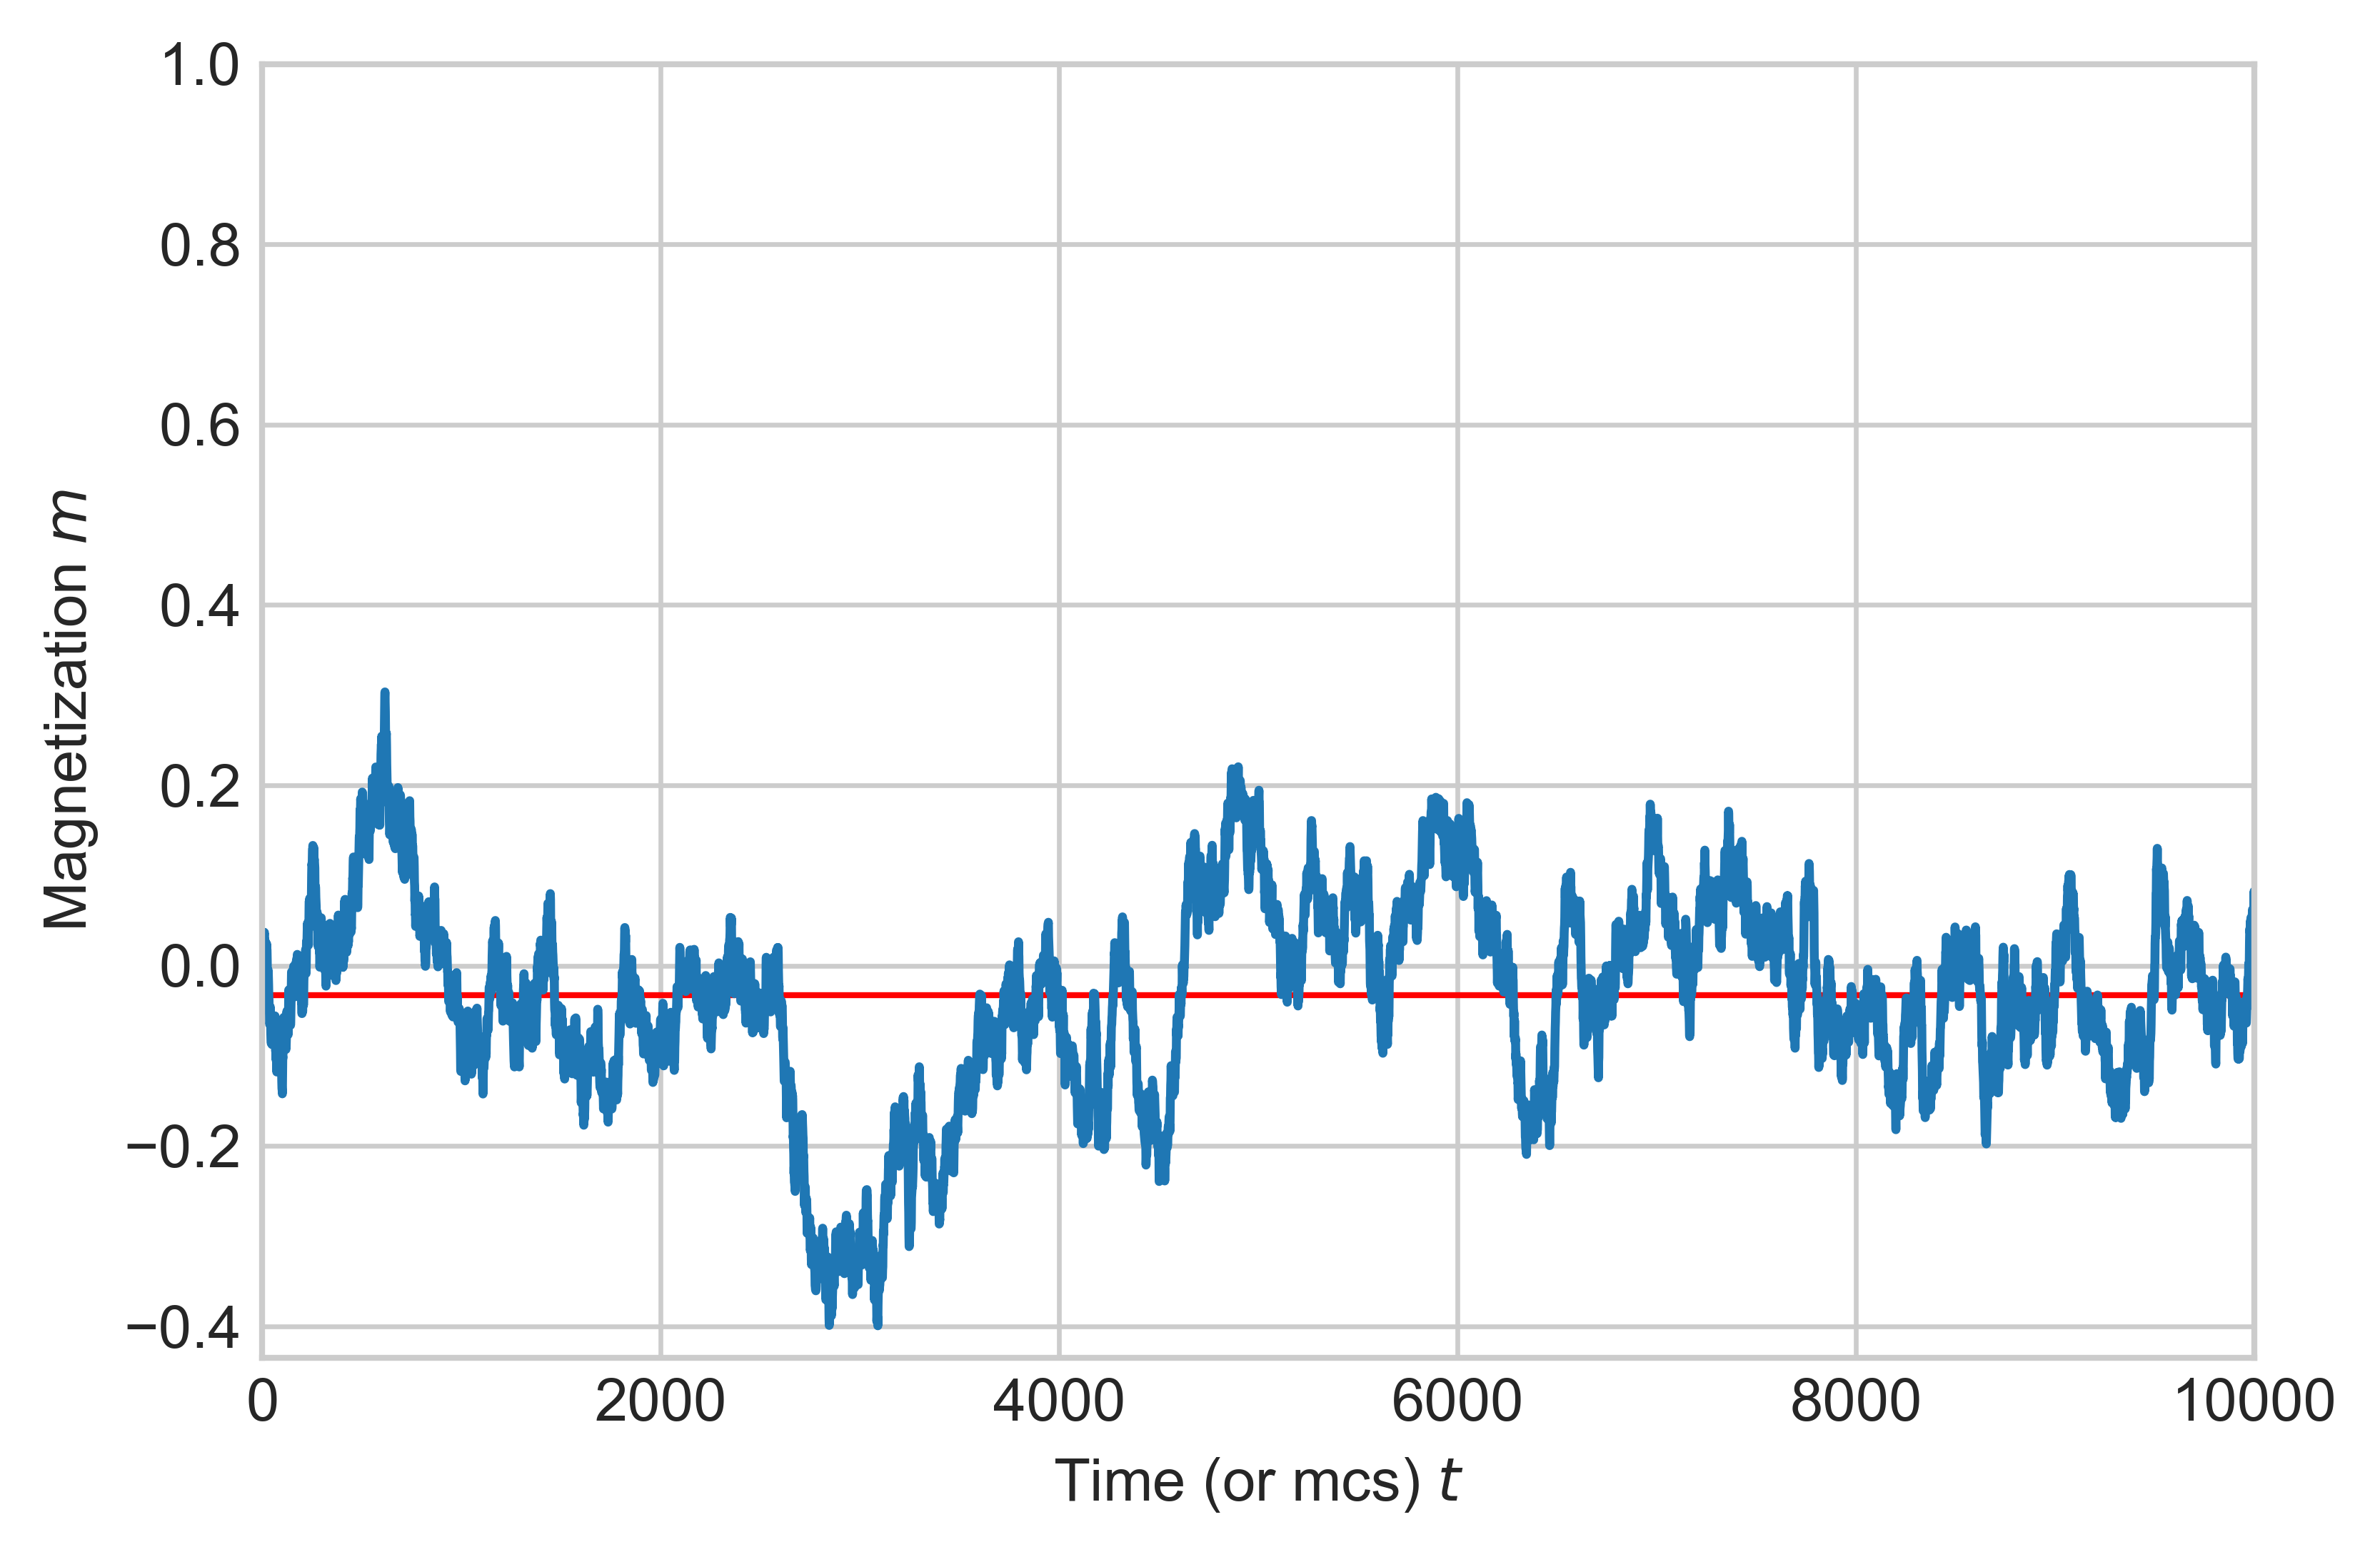

<m> is  -0.032829159999999996


<Figure size 3600x2400 with 0 Axes>

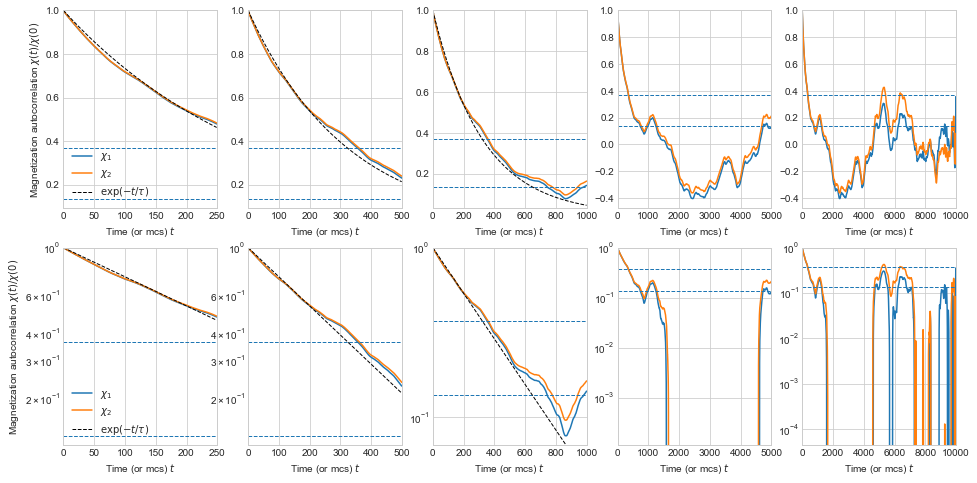

tau is 322.91035443813956


In [25]:
# isTinf = True, Pick Random site = True
exist, mag_fig4 = load_auto_data("Result/mag_fig/np_mag_fig4.txt")
if(not exist):
    mag_fig4 = __auto__(2.4,True,True)
    save_auto_data(mag_fig4,"Result/mag_fig/np_mag_fig4.txt")
tau_drawer_2(mag_fig4)

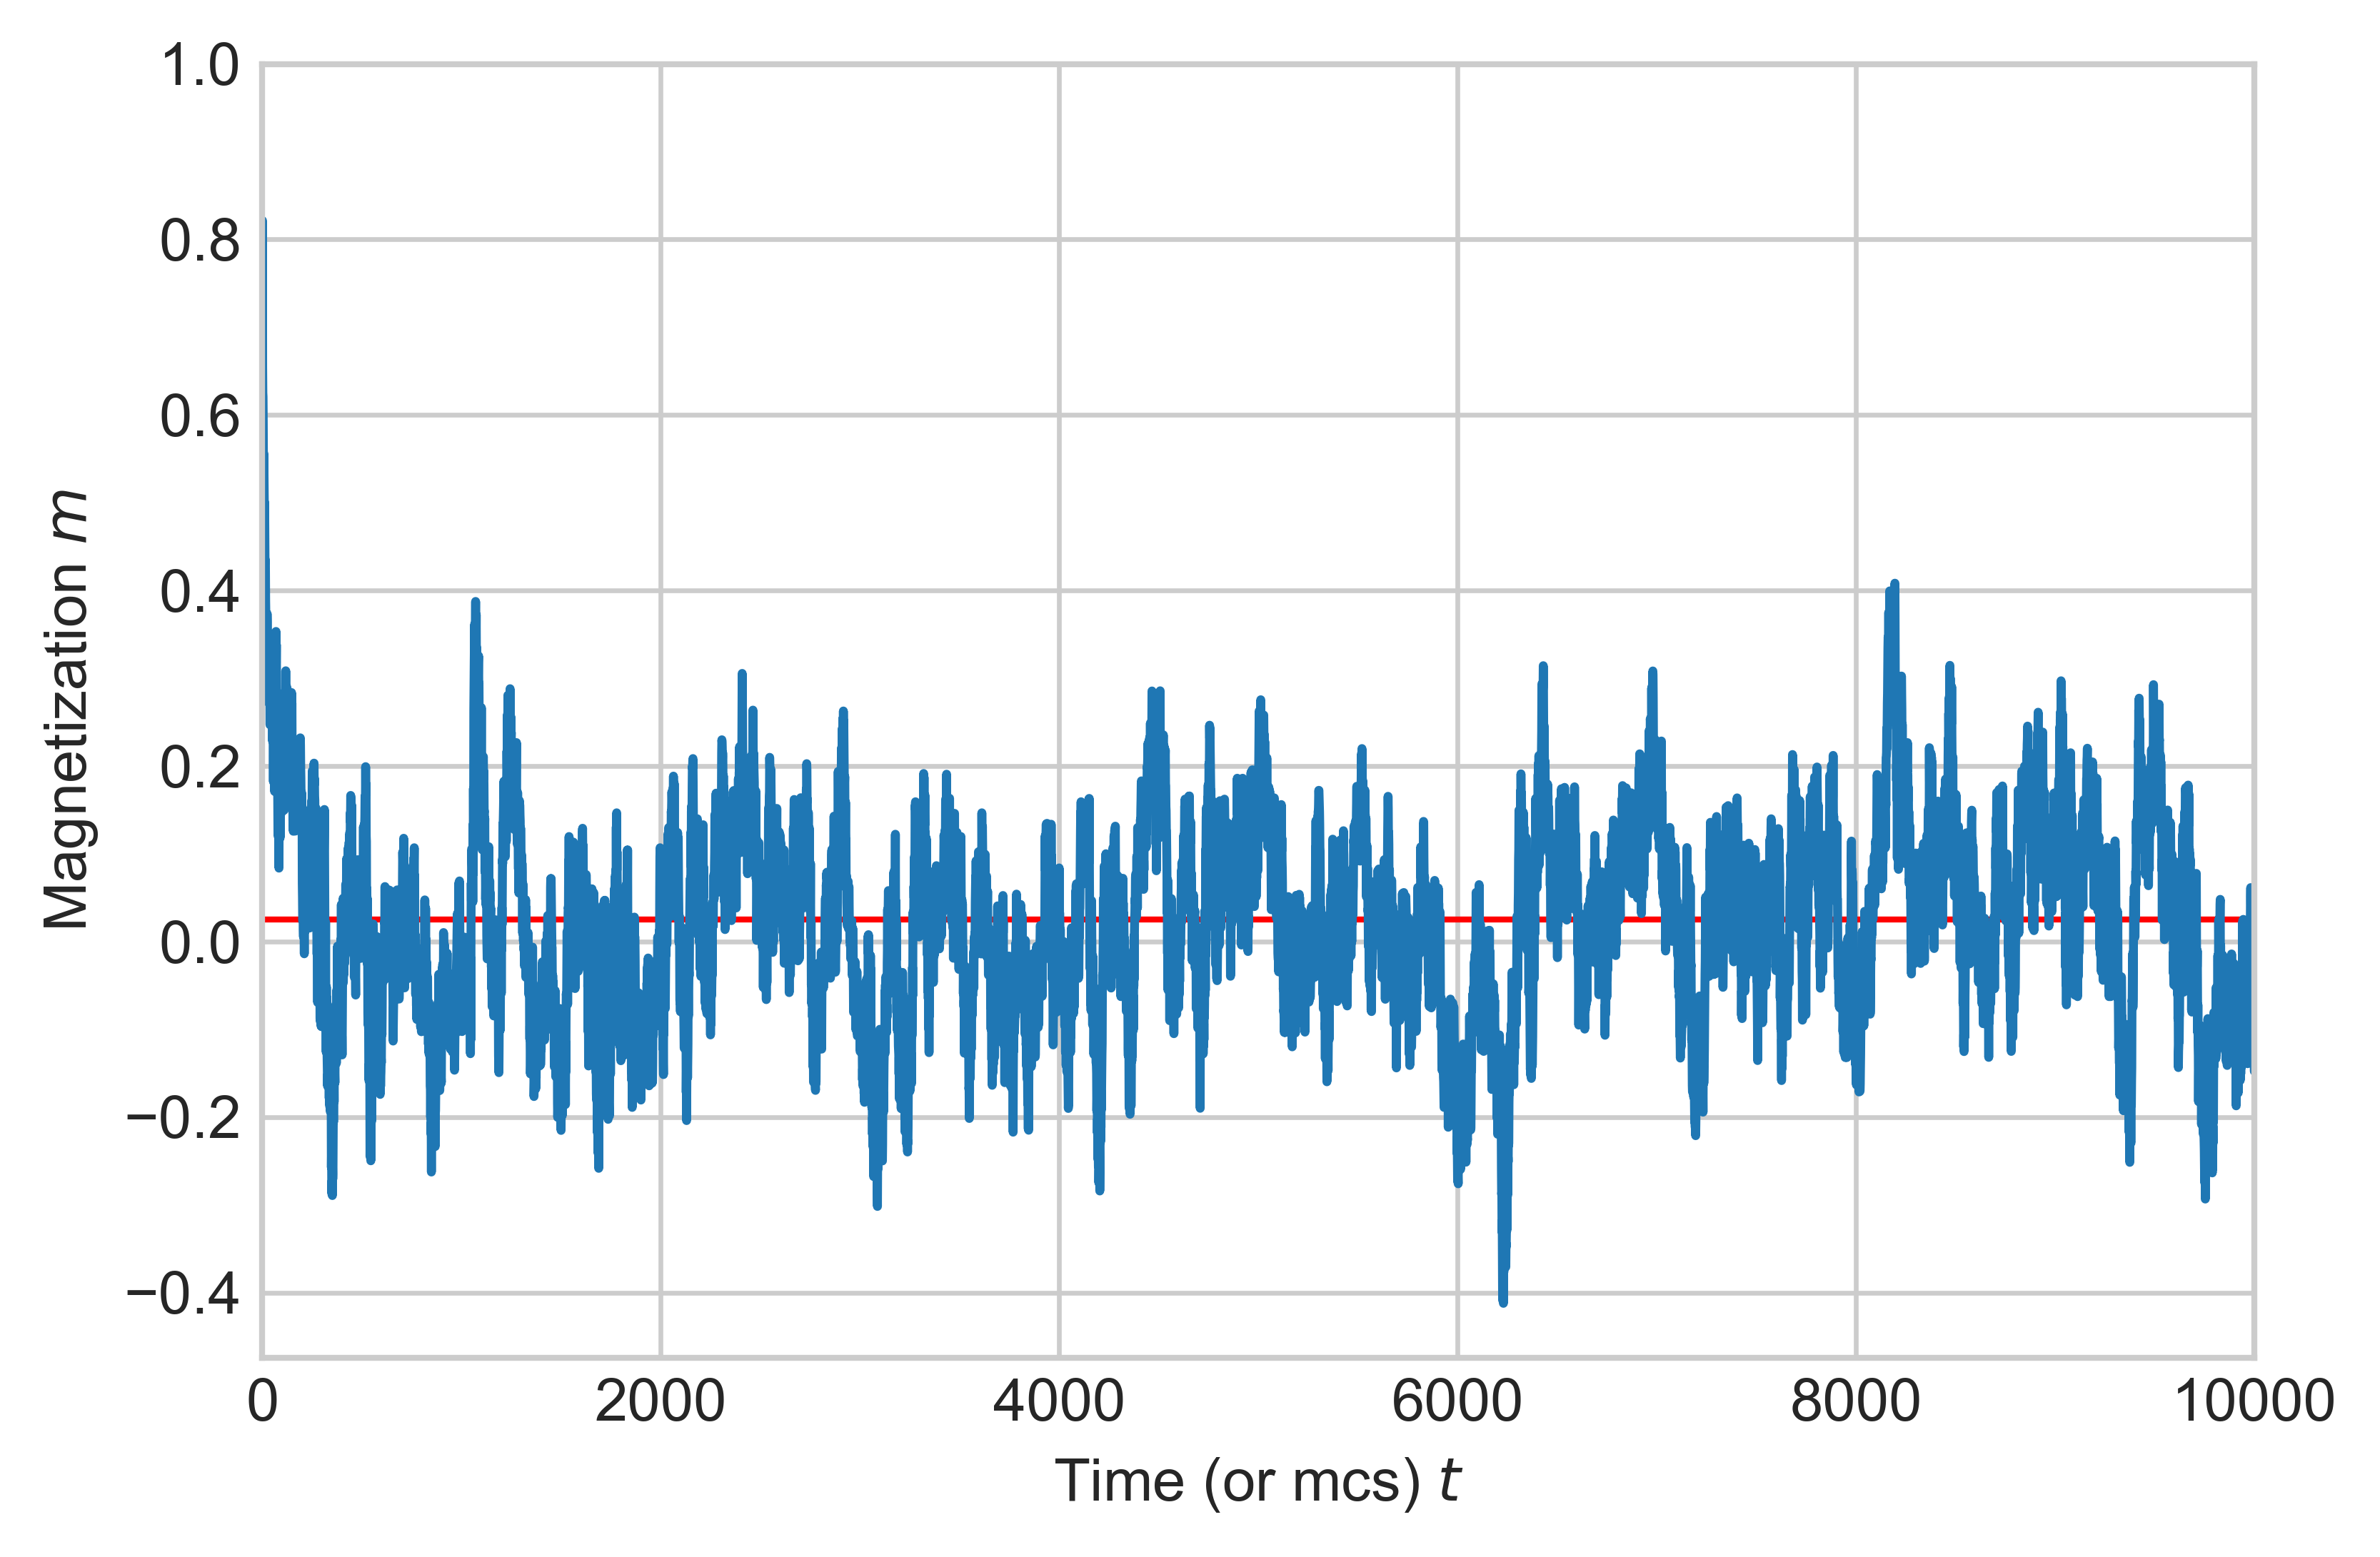

<m> is  0.024948520000000002


<Figure size 3600x2400 with 0 Axes>

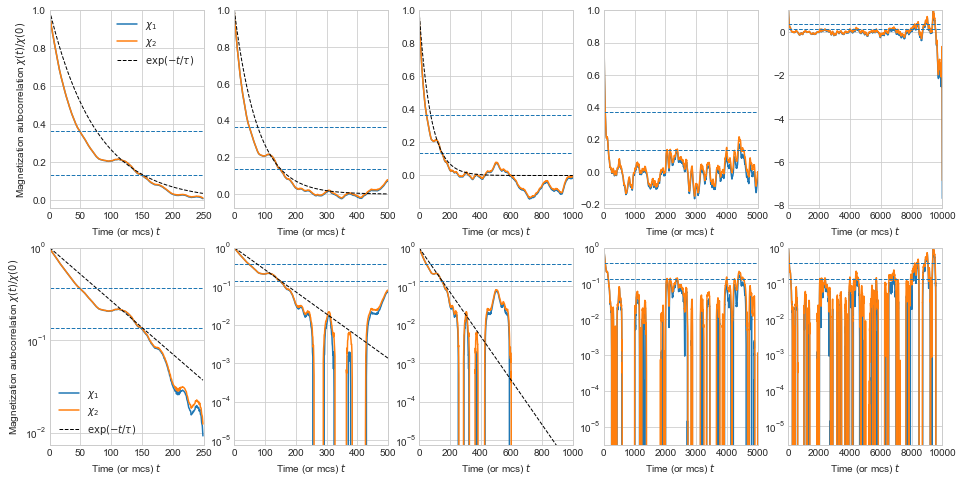

tau is 75.6173983340055


In [26]:
# isTinf = True, Pick Random site = True
exist, mag_fig5 = load_auto_data("Result/mag_fig/np_mag_fig5.txt")
if(not exist):
    mag_fig5 = __auto__(2.4,False,False)
    save_auto_data(mag_fig5,"Result/np_mag_fig5.txt")
tau_drawer_2(mag_fig5)

In [45]:
def tau_drawer_loading(path,length = None,abs = False, draw_fitting = [None], slice = [250,500,1000,5000,10000]):
    # file_stream = open("..\C++\Result\Metropolis_c_Error_100_int25_auto_"+str(1)+".csv",'r')
    file_stream = open(path,'r')
    # file_stream = open("..\C++\Result\Autocorrelation\Abs\Metropolis_c_Error_100_int25_auto_"+str(5)+".csv",'r')

    lines = file_stream.readlines()
    file_stream.close()
    __sample = np.array([np.array(line.strip().split(','),dtype=np.double) for line in lines],dtype=object)
    if(abs):
        __sample = np.abs(__sample)
    print(__sample)

    # __sample = __sample[:][0:1000]
    print(__sample.shape)
    __tTemp = 2.4
    i = 11
    print(__sample[i][0])
    if(length == None):
        auto_chi1 = chi1(__sample[i][1:])
        auto_chi2 = chi2(__sample[i][1:])
        tau_drawer(__sample[i][1:],auto_chi1,auto_chi2,draw_fitting=draw_fitting, slice=slice)
    else :
        auto_chi1 = chi1(__sample[i][1:length])
        auto_chi2 = chi2(__sample[i][1:length])
        tau_drawer(__sample[i][1:],auto_chi1,auto_chi2,draw_fitting=draw_fitting, slice=slice)

        

[[2.2 0.951 -0.909 ... 0.786 0.769 1.0]
 [2.20625 0.9358 -0.891 ... -0.7882 -0.767 1.0]
 [2.2125 0.9392 0.8982 ... 0.765 0.783 1.0]
 ...
 [2.3375 -0.919 -0.8488 ... -0.0592 0.2666 1.0]
 [2.34375 -0.9276 -0.8802 ... 0.1806 0.0948 1.0]
 [2.35 -0.9256 -0.863 ... -0.3342 -0.2842 1.0]]
(25, 200002)
2.26875


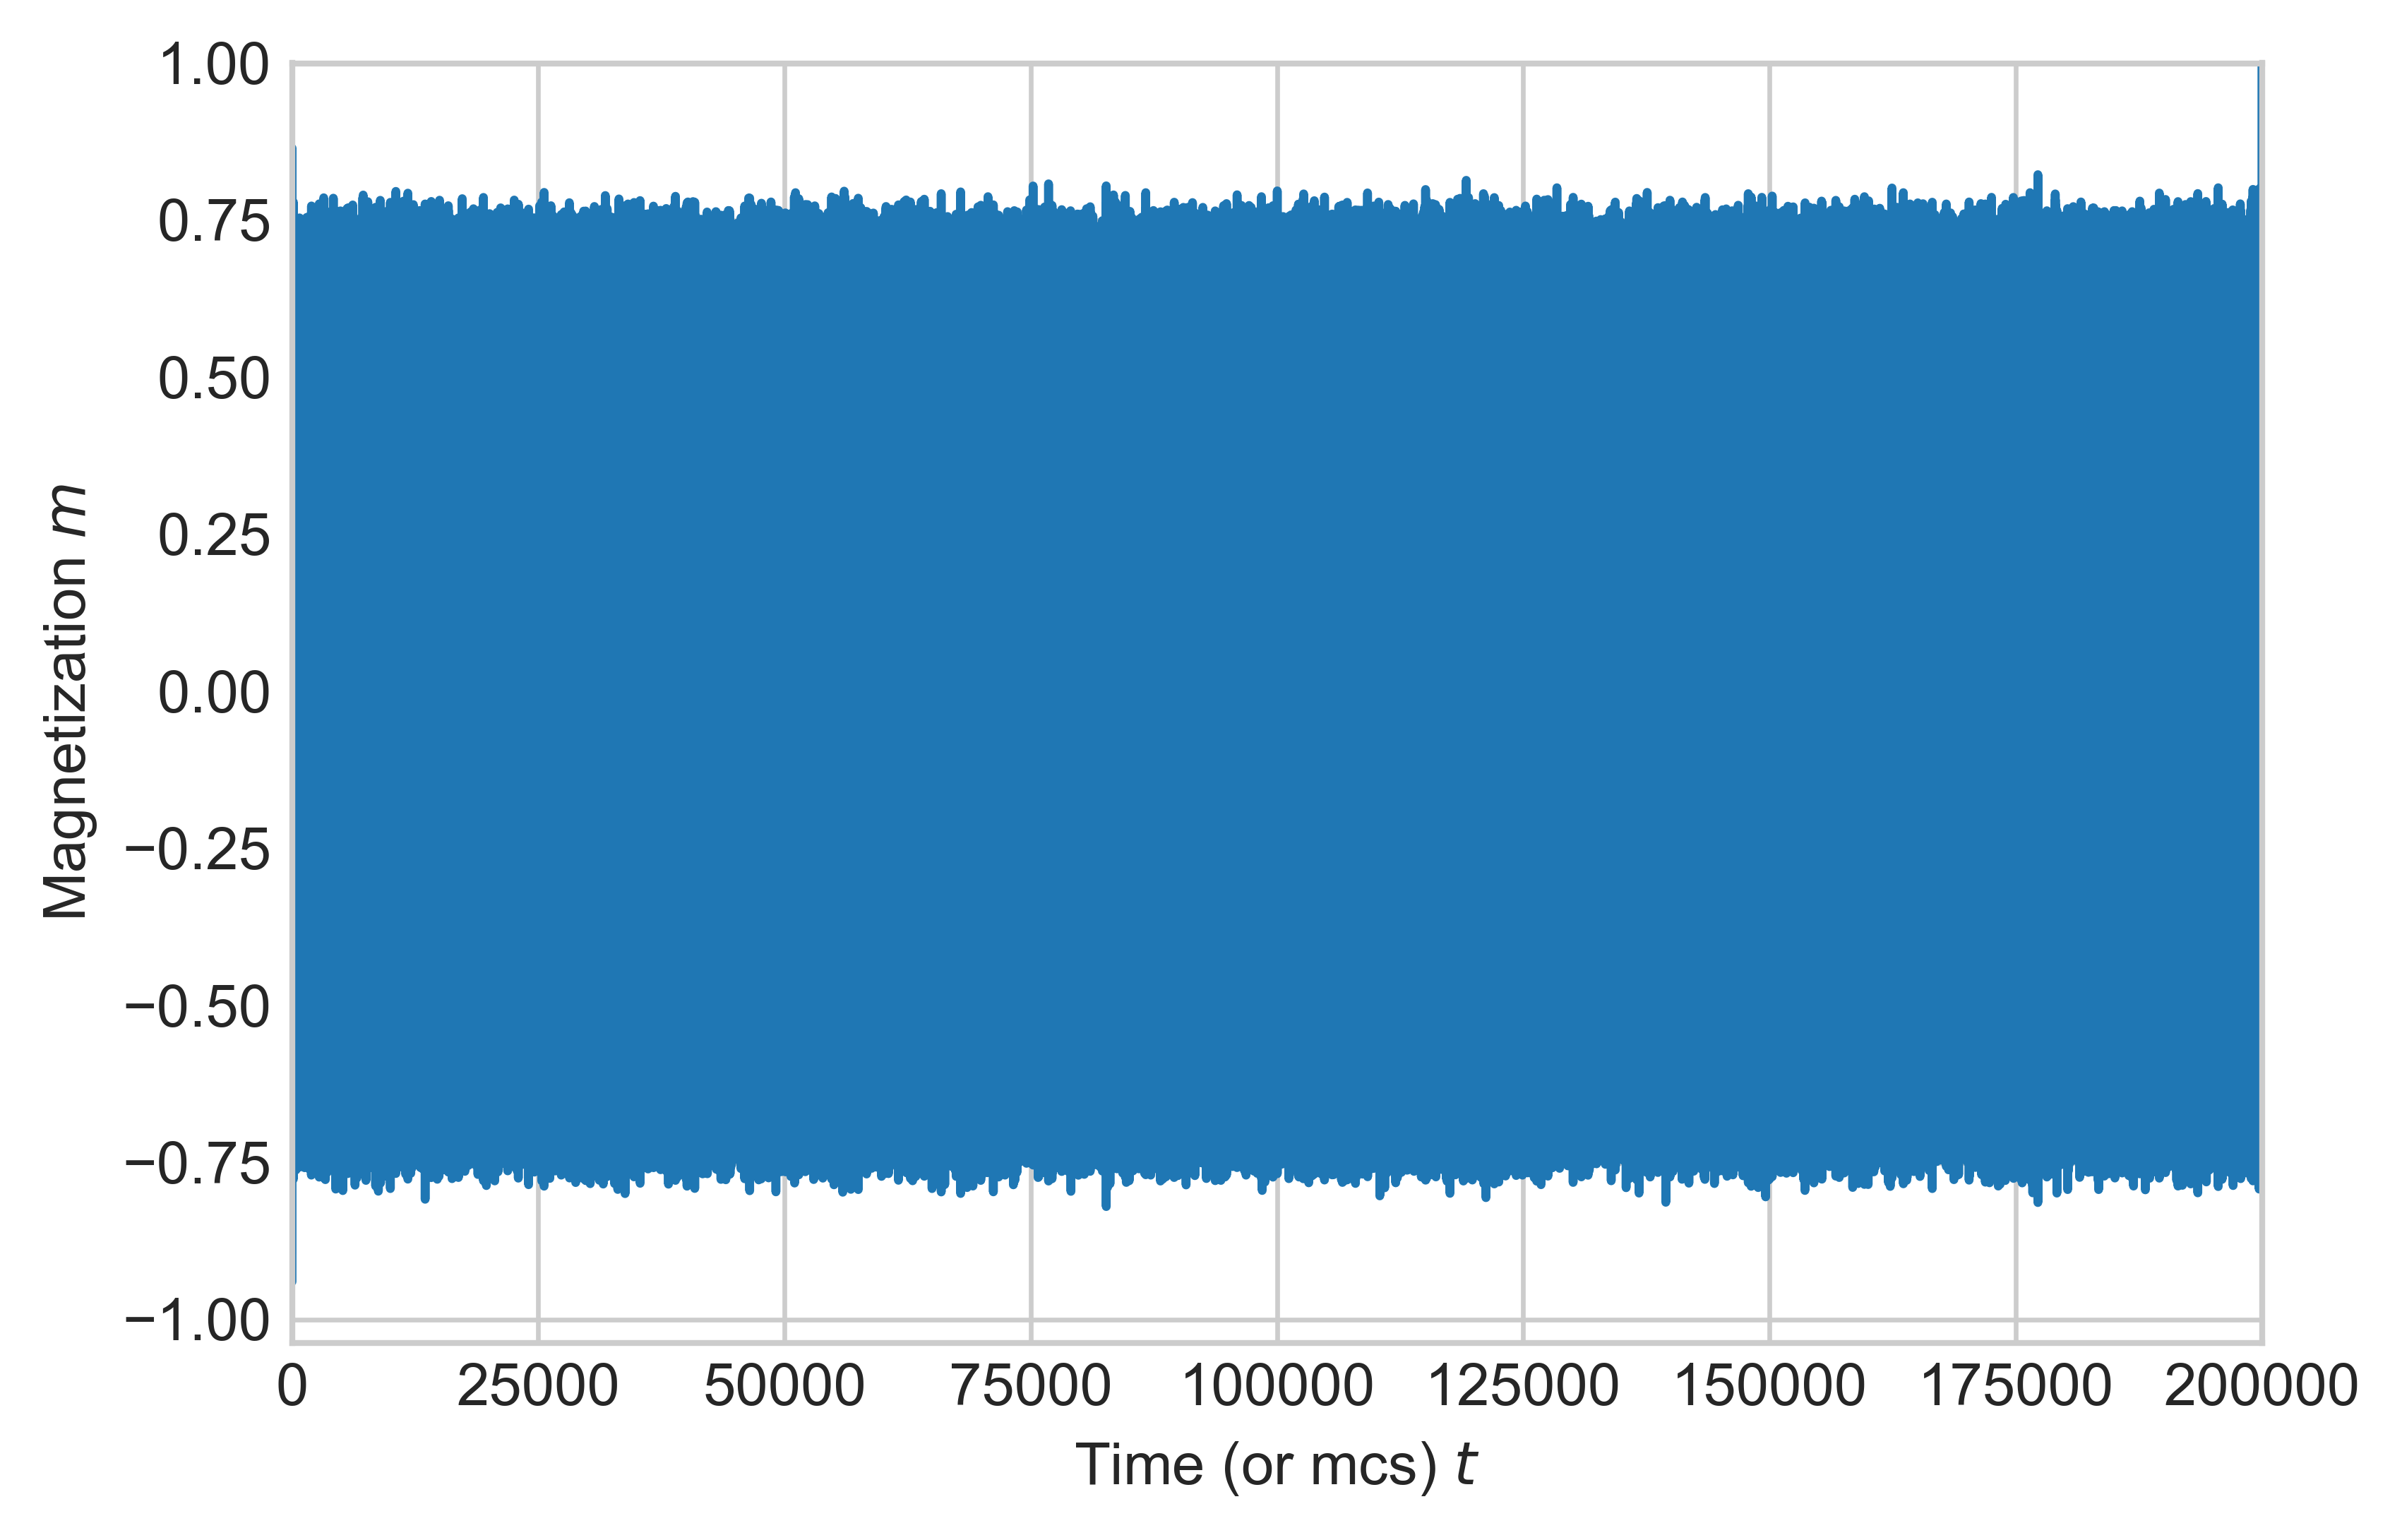

<m> is  0.00046756166219168134


<Figure size 3600x2400 with 0 Axes>

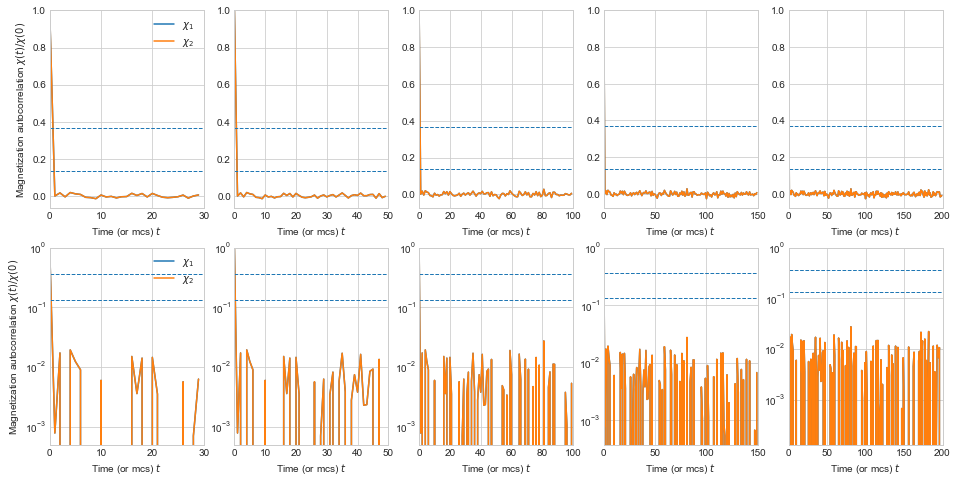

In [49]:
# tau_drawer_loading("..\C++\Result\Metropolis_c_Error_100_int25_auto_"+str(2)+".csv")
tau_drawer_loading("../C++/SwendsenWang/Result/upload/SwendsenWang_HK_c_100_int25_auto2_"+str(2)+".csv", length=10001, draw_fitting=[None], slice = [30,50,100,150,200])

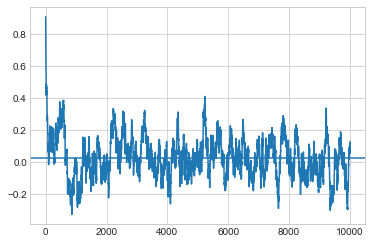

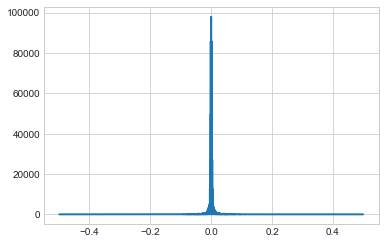

[ 0.      0.0001  0.0002 ... -0.0003 -0.0002 -0.0001]
[1.41651069e-27 5.63140387e+03 1.61219746e+03 ... 1.60118581e+04
 1.61219746e+03 5.63140387e+03]
0.026780400000000003
0.015604954447839998
9.077313834038096e-26


C:\Users\Seongsu\anaconda3\envs\Lab0\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


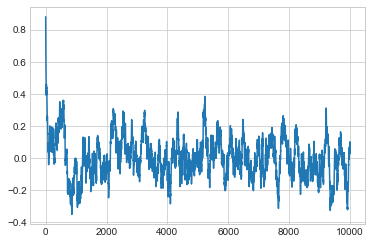

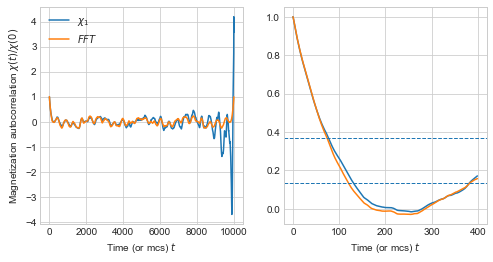

<Figure size 3600x2400 with 0 Axes>

In [38]:
def FFT_ploting(fmlist):
    ## FFT
    plt.style.use('seaborn-whitegrid')
    plt.plot(np.arange(0,len(fmlist)),fmlist)
    # plt.plot(np.arange(0,epoch),mlist**2)
    plt.axhline(np.average(fmlist))
    plt.show()

    # fmlist = np.append(fmlist,np.array([np.average(fmlist)]*10000))

    length = len(fmlist) # length of list


    mp = (fmlist)[:length] - np.average(fmlist[:length])
    fft_chi = abs(np.fft.fft(mp))**2
    frequency = np.fft.fftfreq(len(mp),1)

    plt.style.use('seaborn-whitegrid')
    plt.plot(frequency,fft_chi)
    plt.show()

    susep = np.average(fmlist[:length]**2)-np.average(fmlist[:length])**2
    print("frequency:",frequency)
    print(fft_chi)
    print(np.average(fmlist[:length]))
    print(susep)
    print(fft_chi[0]/susep)
    
    #Recover FFT : complex form?

    chi_inv = np.fft.ifft(np.fft.fft(mp))
    plt.plot(np.arange(0,length),chi_inv)
    plt.show()

    chi_inv = np.fft.ifft(fft_chi)
    auto_chi = chi1(fmlist)

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.plot(np.arange(0,length),auto_chi/auto_chi[0],label="$\chi_1$")
    plt.plot(np.arange(0,length),chi_inv.real/chi_inv.real[0],label="$FFT$")
    plt.ylabel('Magnetization autocorrelation $\chi(t)/\chi(0)$')
    plt.xlabel('Time (or mcs) $t$')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0,400),auto_chi[0:400]/auto_chi[0],label="$\chi_1$")
    plt.plot(np.arange(0,400),chi_inv[:400].real/chi_inv.real[0],label="$FFT$")
    plt.axhline(1/np.e,linestyle='--',lw=1)
    plt.axhline(1/np.e**2,linestyle='--',lw=1)
    plt.xlabel('Time (or mcs) $t$')
    plt.figure(dpi=600)

    plt.show()

FFT_ploting(mag_fig2) 

In [39]:
path = "../C++/SwendsenWang/Result/upload/SwendsenWang_HK_c_100_int25_auto2_"+str(2)+".csv"
file_stream = open(path,'r')
# file_stream = open("..\C++\Result\Autocorrelation\Abs\Metropolis_c_Error_100_int25_auto_"+str(5)+".csv",'r')

lines = file_stream.readlines()
file_stream.close()
__sample = np.array([np.array(line.strip().split(','),dtype=np.double) for line in lines],dtype=object)
if(abs):
    __sample = np.abs(__sample)

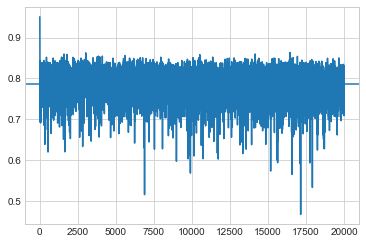

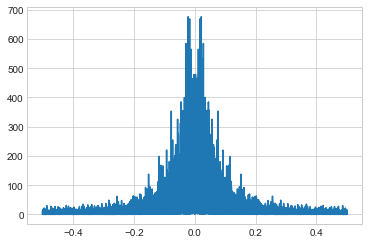

[ 0.0e+00  5.0e-05  1.0e-04 ... -1.5e-04 -1.0e-04 -5.0e-05]
[7.03221342e-20 3.39458153e+02 7.17938574e+01 ... 4.66679062e+00
 7.17938574e+01 3.39458153e+02]
0.7854306800000133
0.0010478439347142432
6.711126710773307e-17


C:\Users\Seongsu\anaconda3\envs\Lab0\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


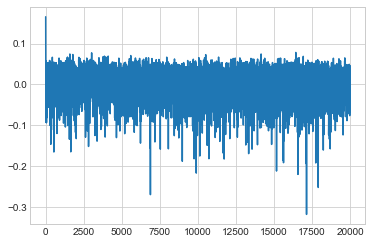

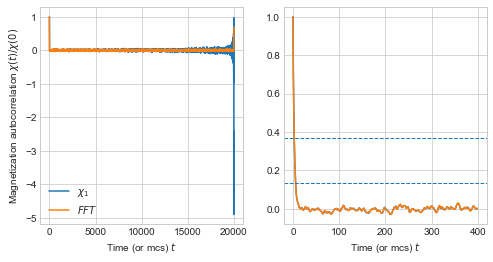

<Figure size 3600x2400 with 0 Axes>

In [44]:
FFT_ploting(__sample[0][1:20001])

In [67]:
## FFT를 이용해서 Metropolis algorithms의 tau의 그래프를 그릴 거임

def find_fft_tau_data(num, path,length = 10000,isWolff = False, abs = False, useStepSize = False):
    # 1. Data를 받아서 정리하는 영역
    file_stream = open(path + str(num) + '.csv',"r")
    lines = file_stream.readlines()
    file_stream.close()
    step_size = 1
    
    if(not isWolff):
        fft_tau_data = np.array([np.array(line.strip().split(',')[1:],dtype=np.double) for line in lines],dtype=object)
    if(isWolff):
        fft_tau_data = np.array([np.array(line.strip().split(',')[1:],dtype=np.double) for line in lines],dtype=object)
        if(useStepSize):
            step_size = np.array([fft_tau_data[i][-1] for i in range(25)])
        fft_tau_data = np.array([fft_tau_data[i][:-1] for i in range(25)])
    if(abs) : fft_tau_data = np.abs(fft_tau_data)


    res = np.zeros(25)
    # 2. Data에 FFT와 IFFT를 가하는 영역
    for i in range(25):
        tau_data_mp = (fft_tau_data[i])[:length] - np.average(fft_tau_data[i][:length])
        tau_data_fft_chi = np.abs(np.fft.fft(tau_data_mp))**2
        # frequency = np.fft.fftfreq(len(tau_data_mp),1)
        tau_data_fft_chi_inv = np.fft.ifft(tau_data_fft_chi).real
        tau_data_fft_chi_inv = tau_data_fft_chi_inv/max(tau_data_fft_chi_inv)
        # print(tau_data_fft_chi_inv.shape)


        # 3. Data에서 1/e가 되는 값을 찾음
        e1 = 1/np.e
        for j in range(length):
            if(tau_data_fft_chi_inv[j] < e1):
                tau = j
                res[i] = tau
                break
        # print(tau)
    if(isWolff):
        res = res*step_size
    return res

def plot_chi_time(tau_data_avg, tau_data_dev_sqrt,start = 0.2, fin=5, bin=25):
    plt.style.use('seaborn-whitegrid')
    plt.figure(dpi=600)
    xx = np.linspace(start,fin,bin)
    plt.plot(xx,tau_data_avg,marker = 's',color='b',label='Teq')
    plt.fill_between(xx,tau_data_avg+tau_data_dev_sqrt,tau_data_avg-tau_data_dev_sqrt,alpha=0.4)
    # plt.xlim(0,5)
    _, ymax = plt.ylim(None)
    # plt.ylim(-10,350)
    plt.axvline(x=2/np.log(1+np.sqrt(2)),c='grey',lw=1,dashes=[2,2])



    plt.ylabel('equilrbrium step Teq')
    plt.xlabel('Temperature T')
    if(start == 0.2 and fin == 5): 
        plt.text(0.05,ymax-3*ymax/50,"100 $\\times$ 100 lattice")
        plt.text(0.06,ymax-6*ymax/50,"20000 steps per site")
        plt.text(0.06,ymax-9*ymax/50,"8 samples of single-spin flip ")
    # plt.text(2.5,183,"185.9$\pm$55")
    # plt.text(2.27,-25, '$T_c$', ha='center')
    plt.legend()
    plt.show()

def tau_data_process(path, num = 8, isWolff = False, abs = False, useStepSize=False):
    tau_data = np.array([find_fft_tau_data(i+1,path,isWolff=isWolff,abs=abs,useStepSize=useStepSize) for i in range(num)])

    # https://ko.wikipedia.org/wiki/%EB%B6%84%EC%82%B0

    tau_data_avg = tau_data.sum(0)/tau_data.shape[0]
    tau_data_dev = (tau_data**2-(np.array([tau_data_avg for i in range(tau_data.shape[0])]))**2).sum(0)/(1 if num == 0 else num-1)
    tau_data_dev_sqrt = np.sqrt(tau_data_dev)
    print(tau_data_avg)
    print(tau_data_dev_sqrt)
    return tau_data_avg, tau_data_dev_sqrt

In [52]:
# tau_data_avg, tau_data_dev_sqrt = tau_data_process("..\C++\Result\Metropolis_c_Error_100_int25_auto_",abs=True)
# plot_chi_time(tau_data_avg, tau_data_dev_sqrt)
# tau_data_avg, tau_data_dev_sqrt = tau_data_process("..\C++\Result\Metropolis_c_Error_100_int25_auto_",abs=False)
# plot_chi_time(tau_data_avg, tau_data_dev_sqrt)

C:\Users\Seongsu\AppData\Local\Temp/ipykernel_23764/2829526163.py:28: RuntimeWarning: invalid value encountered in true_divide
  tau_data_fft_chi_inv = tau_data_fft_chi_inv/max(tau_data_fft_chi_inv)


[0.00000e+00 1.25000e-01 1.62500e+00 1.87500e+00 2.00000e+00 2.00000e+00
 2.00000e+00 2.00000e+00 3.12500e+00 7.12500e+00 7.28750e+01 2.78625e+02
 5.05000e+01 2.27500e+01 1.28750e+01 9.00000e+00 6.87500e+00 5.75000e+00
 5.00000e+00 4.00000e+00 4.00000e+00 3.00000e+00 3.00000e+00 3.00000e+00
 2.87500e+00]
[ 0.          0.35355339  0.51754917  0.35355339  0.          0.
  0.          0.          0.35355339  0.35355339 36.35710777 86.90378506
  9.16515139  2.43486579  0.83452296  0.75592895  0.35355339  0.46291005
  0.          0.          0.          0.          0.          0.
  0.35355339]


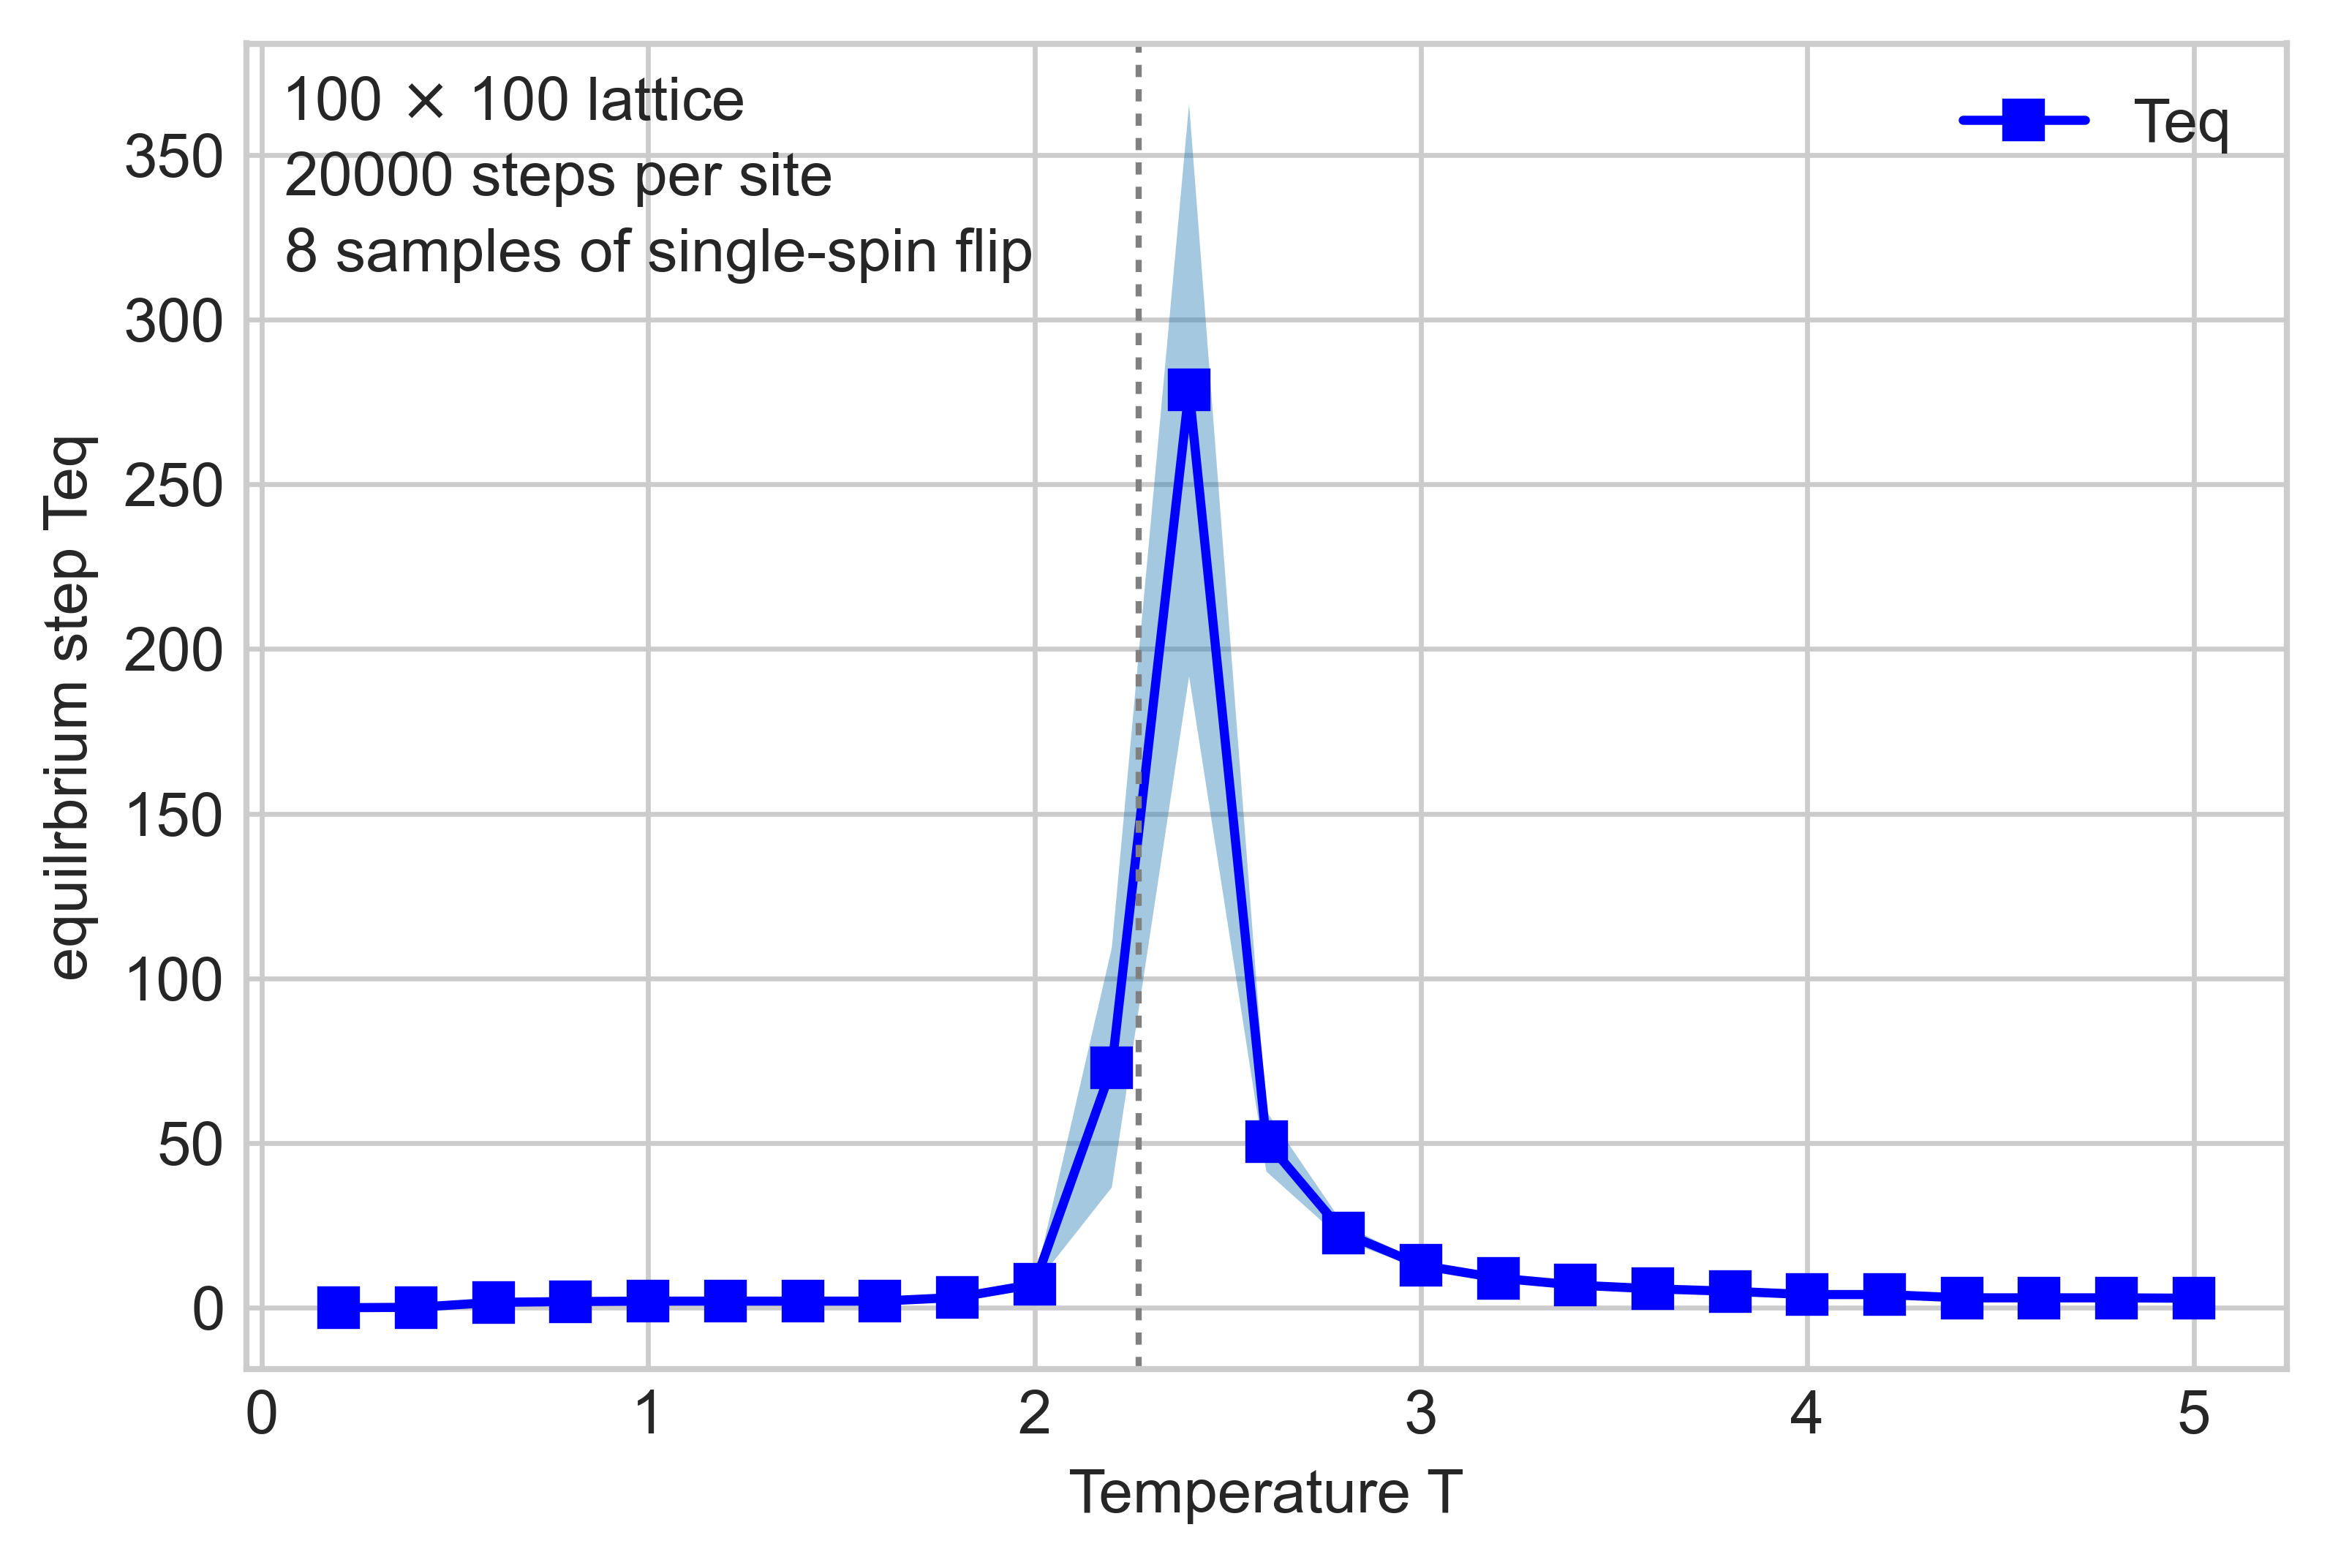

In [53]:
tau_data_avg, tau_data_dev_sqrt = tau_data_process("..\C++\Result\Autocorrelation\Metropolis_c_Error_100_int25_auto_")
plot_chi_time(tau_data_avg, tau_data_dev_sqrt)

In [55]:
# tau_data_avg, tau_data_dev_sqrt = tau_data_process("..\C++\Result\Metro_Result\Metropolis_c_Error_100_int25_auto3_",8)
# plot_chi_time(tau_data_avg, tau_data_dev_sqrt,2.2,2.4,25)

In [57]:
# tau_data_avg, tau_data_dev_sqrt = tau_data_process("..\C++\Result\Metro_Result\Metropolis_c_Error_100_int25_auto3_",1)
# plot_chi_time(tau_data_avg, tau_data_dev_sqrt,2.2,2.4,25)

In [59]:
# tau_data_avg, tau_data_dev_sqrt = tau_data_process("..\C++\Result\Wolff\Wolff_c_100_int25_auto2_",8,isWolff=True,abs=False,useStepSize=True)
# plot_chi_time(tau_data_avg, tau_data_dev_sqrt,2.2,2.4,25)
# tau_data_avg, tau_data_dev_sqrt = tau_data_process("..\C++\Result\Wolff\Wolff_c_100_int25_auto2_",8,isWolff=True,abs=True,useStepSize=True)
# plot_chi_time(tau_data_avg, tau_data_dev_sqrt,2.2,2.4,25)

# tau_drawer_loading("..\C++\Result\Wolff\Wolff_c_100_int25_auto2_"+str(1)+".csv",abs=False,draw_fitting=[None],slice = [250,500,1000,5000])

C:\Users\Seongsu\AppData\Local\Temp/ipykernel_23764/2986656928.py:73: RuntimeWarning: invalid value encountered in true_divide
  tau_data_dev = (tau_data**2-(np.array([tau_data_avg for i in range(tau_data.shape[0])]))**2).sum(0)/(1 if num == 0 else num-1)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]


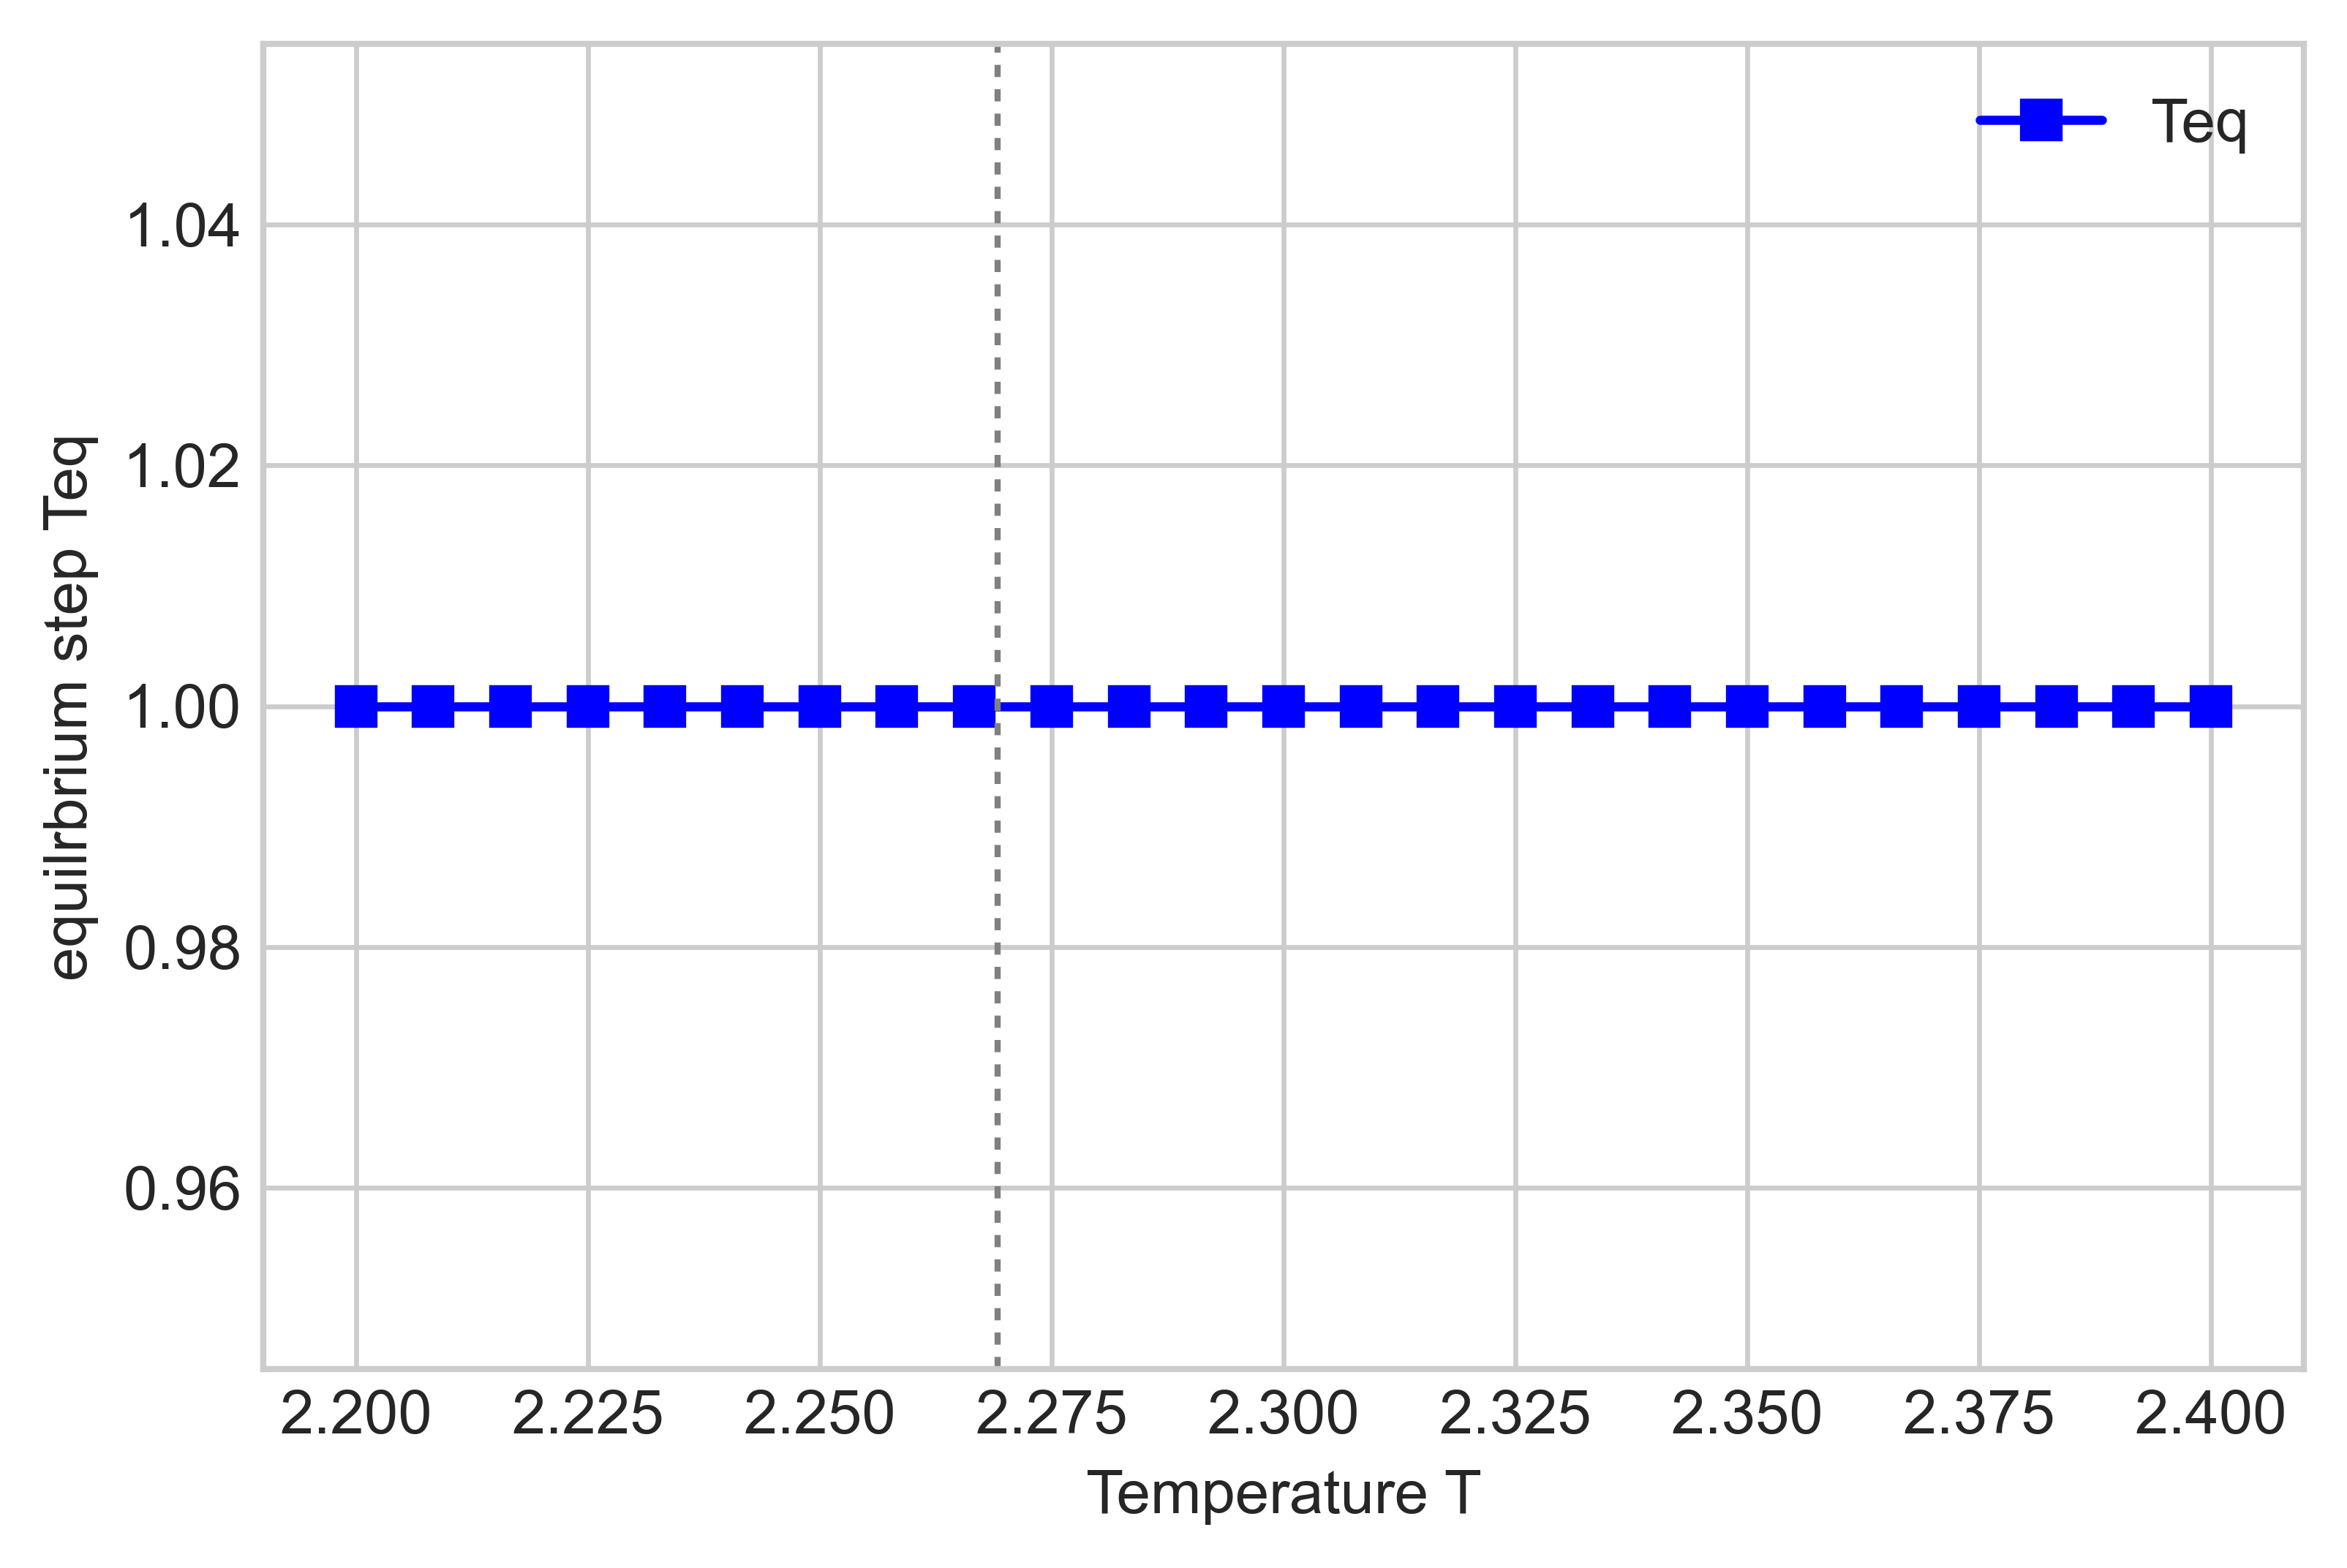

In [68]:
tau_data_avg, tau_data_dev_sqrt = tau_data_process("../C++/SwendsenWang/Result/upload/SwendsenWang_HK_c_100_int25_auto2_",1)
# "../C++/SwendsenWang/Result/upload/SwendsenWang_HK_c_100_int25_auto2_"+str(2)+".csv"
plot_chi_time(tau_data_avg, tau_data_dev_sqrt,2.2,2.4,25)

In [72]:
find_fft_tau_data(1,"../C++/SwendsenWang/Result/upload/SwendsenWang_HK_c_100_int25_auto2_",abs=True,length=30000)

array([3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3.,
       2., 2., 2., 1., 1., 1., 1., 1.])

In [ ]:
# plt.plot(np.arange(0,epoch),mlist)
# plt.axhline(m_expec)
# plt.show()

# _bin2 = 200
# x = np.arange(0,_bin2)
# y = auto_chi[0:_bin2]
# tt, C_p = np.polyfit(x,np.log(y),1,w=np.sqrt(y),cov= True)

# TT = np.vstack([x**(1-i) for i in range(2)]).T
# yi = np.dot(TT,tt)
# C_yi = np.dot(TT,np.dot(C_p,TT.T))
# sig_yi = np.sqrt(np.diag(C_yi))

# slice = [600,1000,5000,10000]
# _bin = slice[0]
# # plt.subplot(2,1,1)
# fig, ax = plt.subplots(1,1)
# # plt.plot(np.arange(0,_bin),auto_chi[0:_bin]/auto_chi[0])
# # plt.plot(np.arange(0,_bin),auto_chi2[0:_bin]/auto_chi2[0])
# ax.fill_between(x, np.exp(yi+sig_yi)/max(np.exp(yi)), np.exp(yi-sig_yi)/max(np.exp(yi)), alpha=.25)
# plt.axhline(1/np.e,linestyle='--',lw=1)
# plt.axhline(1/np.e**2,linestyle='--',lw=1)
# plt.plot(x,np.exp(yi)/max(np.exp(yi)))